# Exercise 1: Optimize lepton selection

* First, print the distributions of the relevant variables for *all* the Monte Carlo samples (i.e. all the *channels* of the $Z$-boson decay to be studied). Which variables are these? Give sensible ranges to include all the events in the samples (both MC and OPAL data) 
* Do the same for **one** of the OPAL data samples (your lab assistant will decide which one you choose).
* Describe the results.
* Optimize the object selection by applying cuts. Make a strategy on how to proceed to find the optimal selection. which information do you need? in thin the
* Determine the efficiency and the amount of background for each $Z$ decay channel. Use the simulated events $e^+e^-$, $\mu^+\mu^-$, $\tau^+\tau^-$ and hadrons ($qq$). Represent the result in a matrix form and think carefully about how you have to correct the measured rates. Don't forget to calculate the errors!
* How do we estimate the statistical fluctuations per bin?

### Download missing libraries
Comment in the following two lines in case some of the libraries cannot be imported. Please restart the kernel after download+upgrade has successfully finished

In [2]:
### Download libraries
#%pip install uproot 
#%pip install awkward 
#%pip install mplhep 
#%pip install numpy 
#%pip install matplotlib 
#%pip install scipy

### Upgrade libraries to latest version
#%pip install uproot awkward mplhep numpy matplotlib scipy --upgrade

### Import libraries

In [3]:
import uproot #for the OPAL data and to use root
import awkward as ak
import mplhep
%matplotlib inline
import numpy as np #for calculations
import matplotlib.pyplot as plt #to plot

import csv #using "csv" to import the Luminosities
from scipy.optimize import curve_fit #for fitting

In [4]:
colors = {'e' : 'b', 'm' : 'r', 't' : 'g', 'q' : 'y', 'mix' : 'black', 'es' : 'cornflowerblue', 'ecut' : 'lightblue', 'mcut' : 'Salmon', 'tcut' : 'limegreen', 'qcut' : 'gold', 'et': 'mediumorchid'}
figsize=(10,7)

In [5]:
path_mc = 'opal_data/mc/' #Import path for MC data

fileee = uproot.open(path_mc+'ee.root') # electron data
filemm = uproot.open(path_mc+'mm.root') # muon data
filett = uproot.open(path_mc+'tt.root') # tauon data
fileqq = uproot.open(path_mc+'qq.root') # hadronic data

files = [fileee, filemm, filett, fileqq] # list of data sets in uproot form

ttree_name = 'myTTree'

## Load branches to akward high level array
branchesee = files[0][ttree_name].arrays() #Electronic brances of the MC data
branchesmm = files[1][ttree_name].arrays() #Muonic brances ''
branchestt = files[2][ttree_name].arrays() #Tauon branches ''
branchesqq = files[3][ttree_name].arrays() #Quarks ''


branchessum = 0 # Dummy variable for the sum of MC data
branchesREAL = 0 # Dummy variable for the measured OPAL data



# List of all MC data sets
brancheses = [branchesee, branchesmm, branchestt, branchesqq, branchessum, branchesREAL] #List of all Branches

## List of measured quantities
var = ['Ncharged', 'Pcharged', 'E_ecal', 'E_hcal', 'E_lep', 'cos_thru', 'cos_thet', 'run', 'event']

# Lists for the data of measured quantities
pchares = [0] * 6 # 4 Times the MC data, 1 time the sum of MC and 1 Time the measured data
nchares = [0] * 6
eecal = [0] * 6
ehcal = [0] * 6
elep = [0] * 6
costhru = [0] * 6
costhet = [0] * 6

run = [0] * 6
event = [0] * 6
i = 0
# Loop over the four particle types
while i < 4:
    nchares[i] = ak.to_numpy(brancheses[i][var[0]]) #copy from strange array to nomal array.
    pchares[i] = ak.to_numpy(brancheses[i][var[1]])
    eecal[i] = ak.to_numpy(brancheses[i][var[2]])
    ehcal[i] = ak.to_numpy(brancheses[i][var[3]])
    elep[i] = ak.to_numpy(brancheses[i][var[4]])
    costhru[i] = ak.to_numpy(brancheses[i][var[5]])
    costhet[i] = ak.to_numpy(brancheses[i][var[6]])
    run[i] = ak.to_numpy(brancheses[i][var[7]])
    event[i] = ak.to_numpy(brancheses[i][var[8]])
    i += 1

# Add the cummulative data of all particle events to one list. 
#This is done to simulate a whole data set as given from the Detector later on.
nchares[4] = np.concatenate((nchares[:4]),axis=None) # Sum the MC data to a total array
pchares[4] = np.concatenate((pchares[:4]),axis=None)
eecal[4] = np.concatenate((eecal[:4]),axis=None)
ehcal[4] = np.concatenate((ehcal[:4]),axis=None)
elep[4] = np.concatenate((elep[:4]),axis=None)
costhru[4] = np.concatenate((costhru[:4]),axis=None)
costhet[4] = np.concatenate((costhet[:4]),axis=None)
run[4] = np.concatenate((run[:4]),axis=None)
event[4] = np.concatenate((event[:4]),axis=None)

# Re create a "high level array", for the MC cummulative data.
brancheses[4] = ak.Array([
    {"run": run[4], "event": event[4], 'Ncharged' : nchares[4], 'Pcharged' : pchares[4], 'E_ecal' : eecal[4], 'E_hcal' : ehcal[4], 'E_lep' : elep[4], 'cos_thru' : costhru[4], 'cos_thet' : costhet[4]} 
    ])


The last line shows all the variables available in the TTree to carry out the experiment. The meaning of these is described in the following table

| Variable name | Description |
| --- | --- | 
| <pre>run</pre> | Run number |
| <pre>event</pre> | Event number |
| <pre>Ncharged</pre> | Number of charged tracks |
| <pre>Pcharged</pre> | Total scalar sum of track momenta |
| <pre>E_ecal</pre> | Total energy measured in the electromagnetic calorimeter |
| <pre>E_hcal</pre> | Total energy measured in the hadronic calorimete |
| <pre>E_lep</pre> | LEP beam energy (=$\sqrt{s}/2$) |
| <pre>cos_thru</pre> | cosine of the polar angle between beam axis and thrust axis |
| <pre>cos_thet</pre> | cosine of the polar angle between incoming positron and outgoing positive particle |

### Cut selection in the MC data

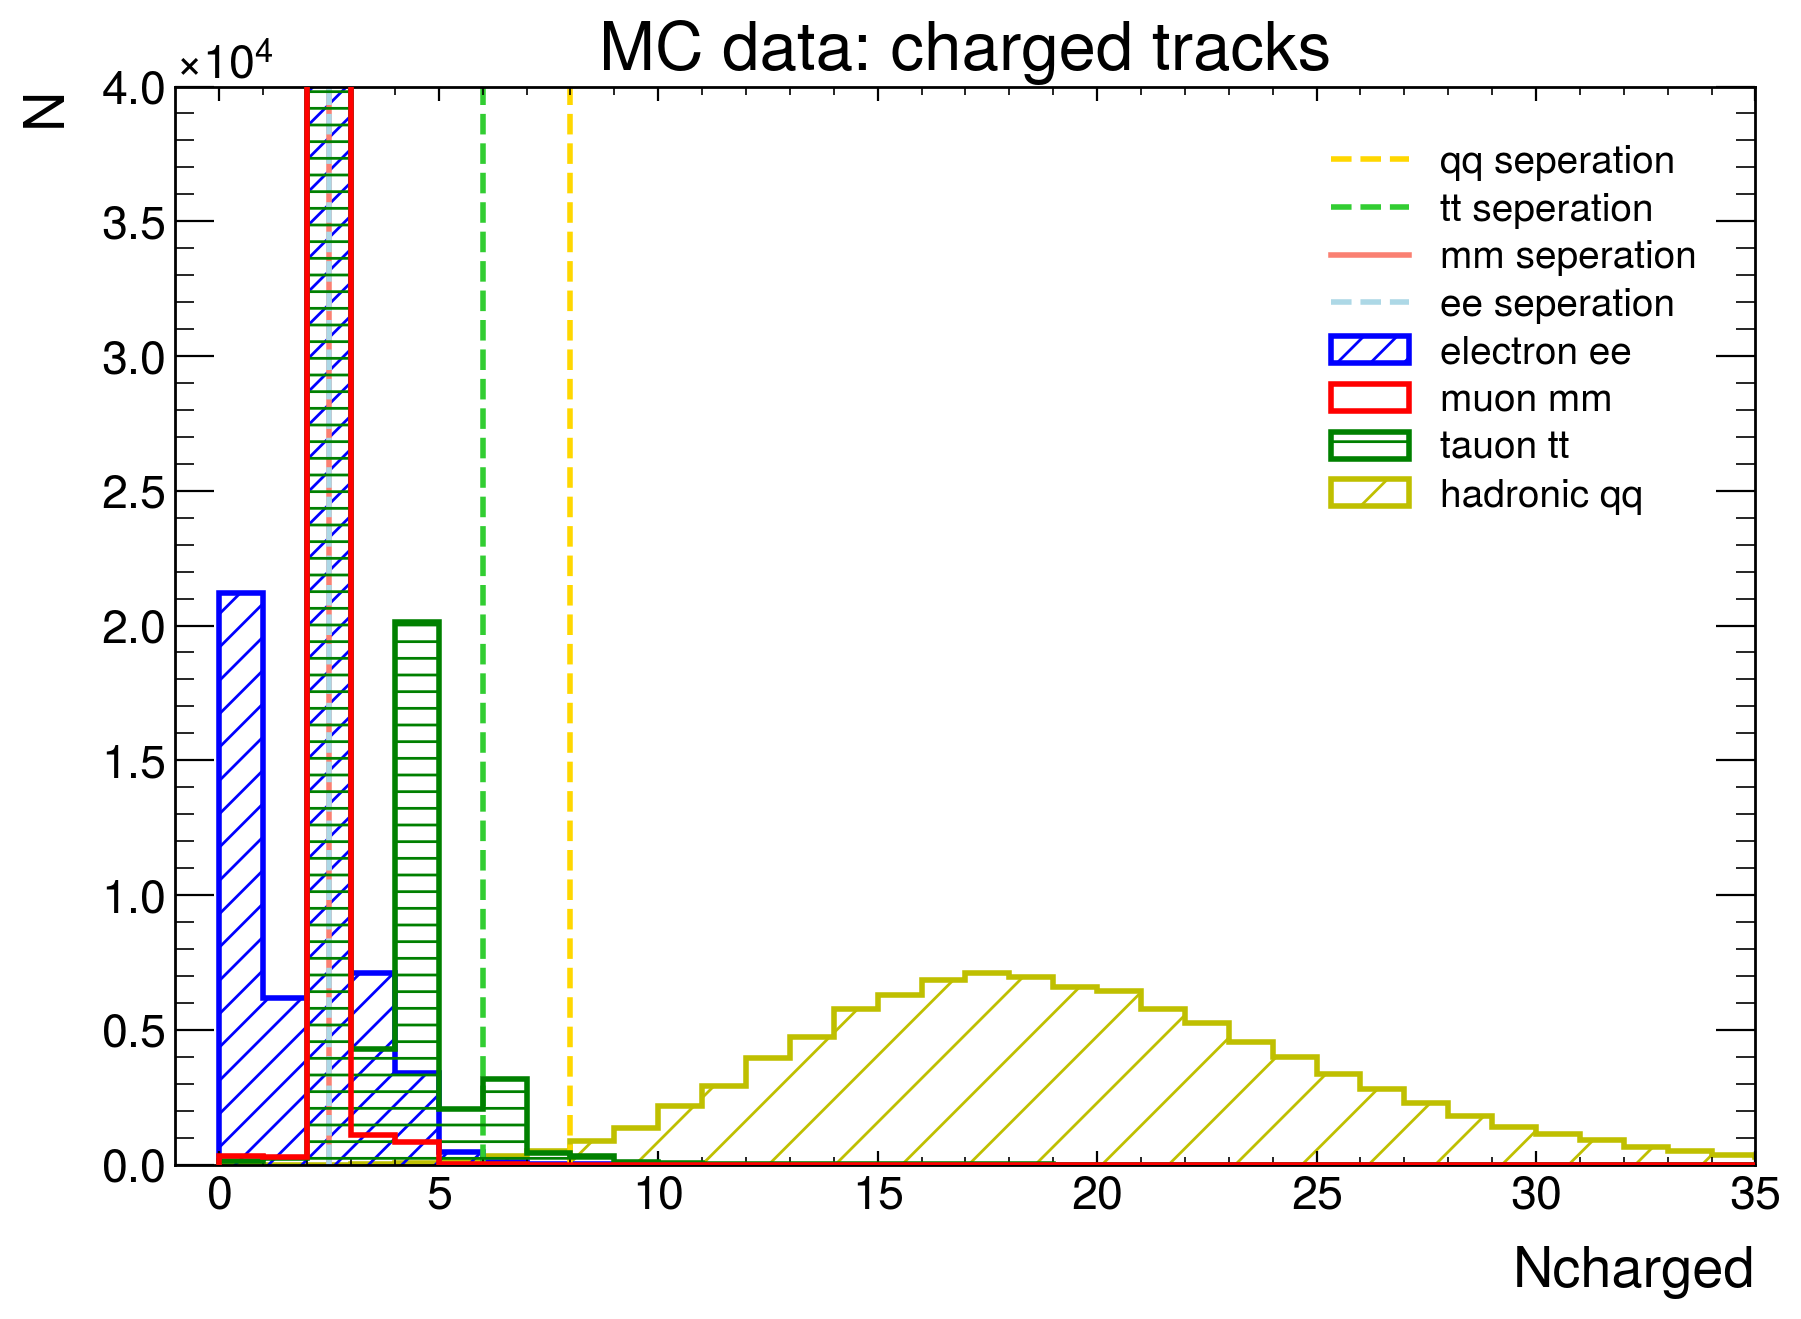

In [6]:
# Histogram the MC data of the charged traces
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=figsize)



bin_content, bin_edges, _ = plt.hist(nchares[0], bins=100, range=(0.,100.), histtype='step',  linewidth=2, edgecolor=colors['e'], hatch='//', label='electron ee', zorder=2)
bin_content, bin_edges, _ = plt.hist(nchares[1], bins=100, range=(0.,100.), histtype='step',  linewidth=2, edgecolor=colors['m'], hatch='', label='muon mm', zorder=4)
bin_content, bin_edges, _ = plt.hist(nchares[2], bins=100, range=(0.,100.), histtype='step',  linewidth=2, edgecolor=colors['t'], hatch='--', label='tauon tt', zorder=3)
bin_content, bin_edges, _ = plt.hist(nchares[3], bins=100, range=(0.,100.), histtype='step',  linewidth=2, edgecolor=colors['q'], hatch='/', label='hadronic qq', zorder=1)
#bin_content, bin_edges, _ = plt.hist(nchares[4], bins=100, range=(0.,100.), histtype='step',  linewidth=2, edgecolor=colors['mix'], hatch='/', label='sum', zorder=1)

#vicualize the seperation cuts
ax = plt.axvline(x=8, color = colors['qcut'], ls = '--', label = 'qq seperation')
plt.axvline(x=6, color = colors['tcut'], ls = '--', label = 'tt seperation')
plt.axvline(x=2.5, color = colors['mcut'], ls = '-', label = 'mm seperation')
plt.axvline(x=2.5, color = colors['ecut'], ls = '--', label = 'ee seperation')


### Show the plot on screen
plt.legend()
plt.title('MC data: charged tracks')
plt.xlim(-1,35)
plt.ylim(0,40e3)
plt.xlabel('Ncharged')
plt.ylabel('N')
plt.savefig('Plots/MC_N_charged.svg', bbox_inches='tight')
plt.show()

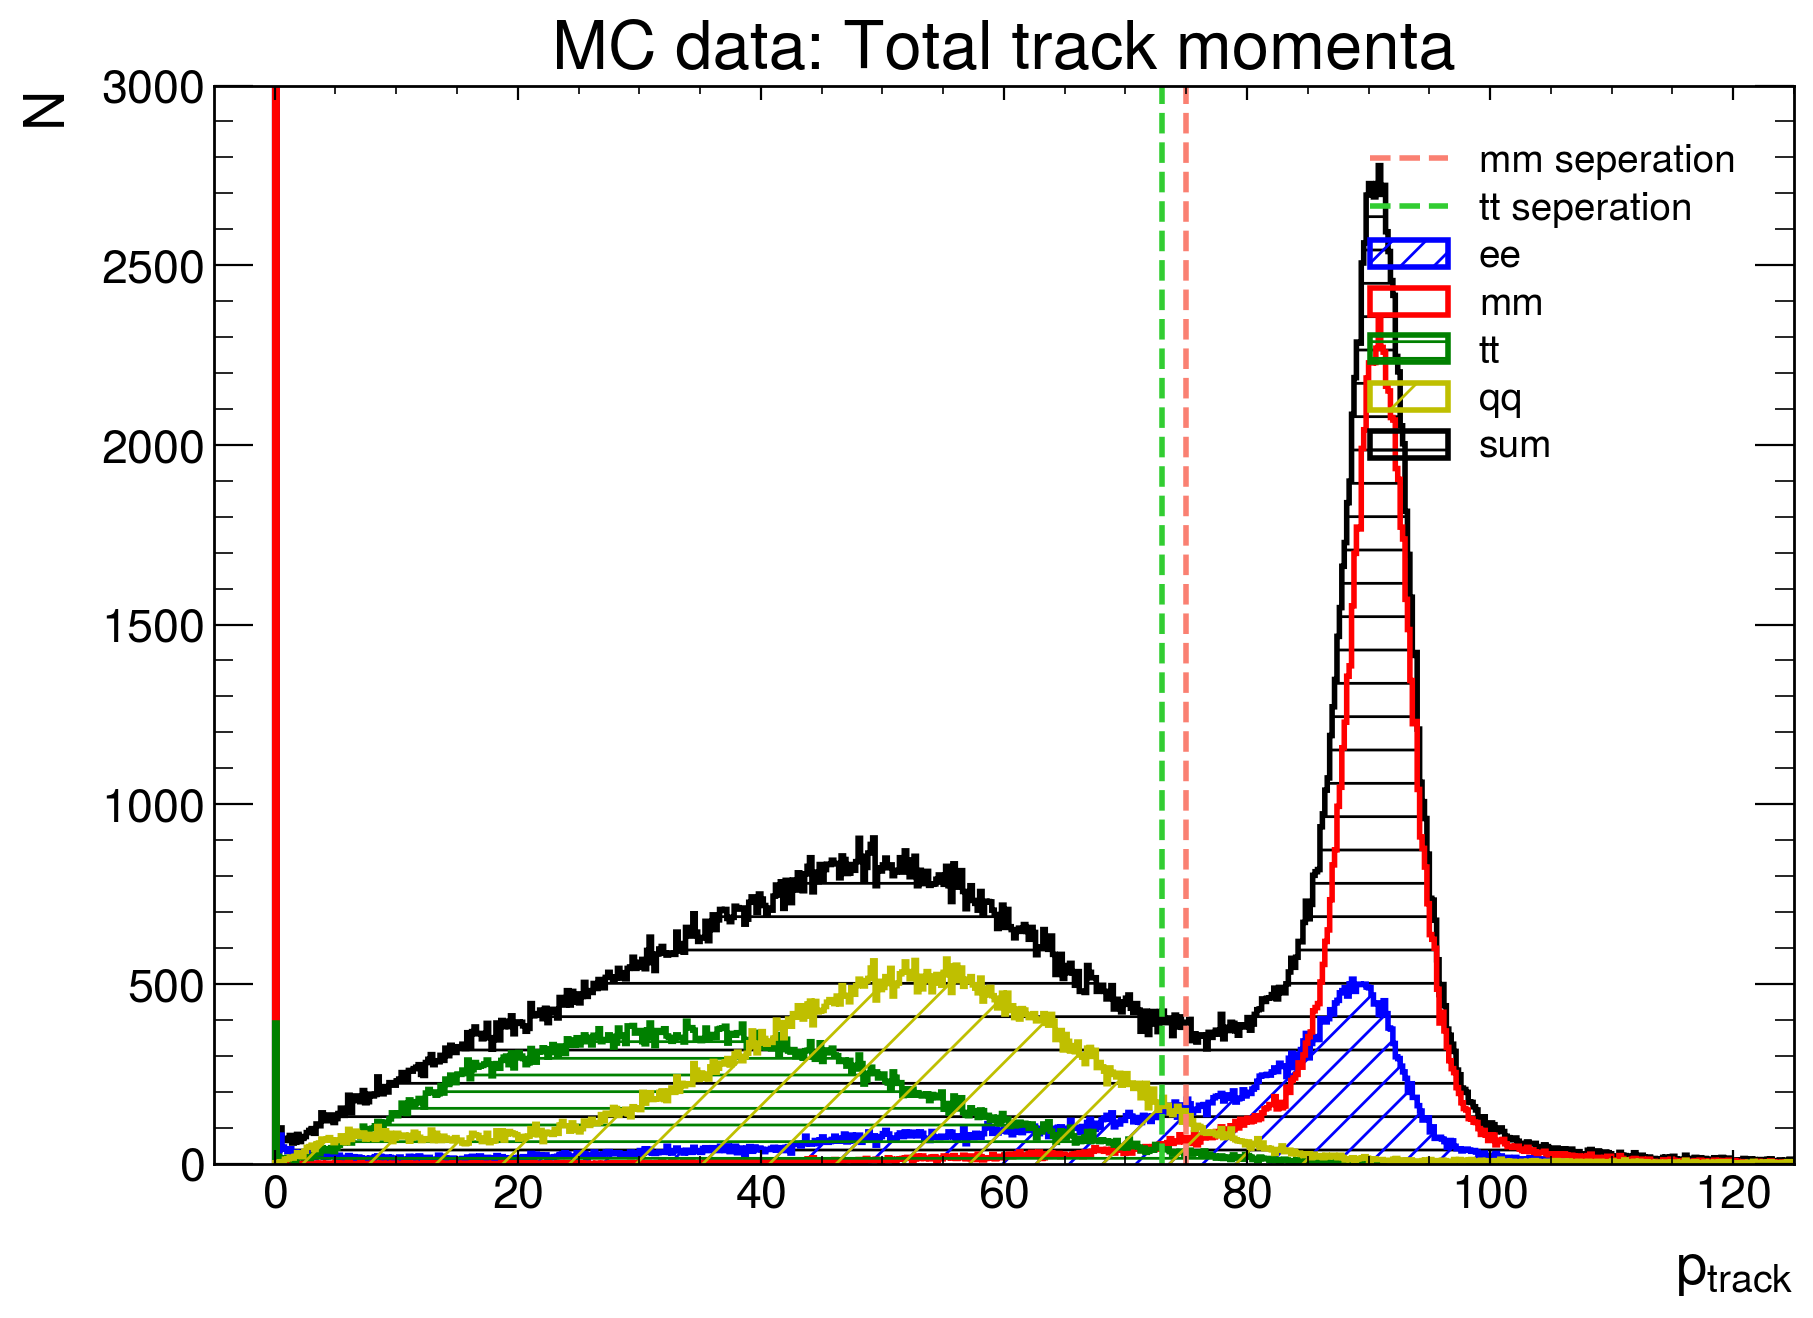

In [7]:
# Plot of the total particle 
plt.style.use(mplhep.style.ATLAS) 
plt.figure(figsize=figsize)

bin_content, bin_edges, _ = plt.hist(pchares[0], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor=colors['e'], hatch='//', label='ee')
bin_content, bin_edges, _ = plt.hist(pchares[1], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor=colors['m'], hatch='', label='mm')
bin_content, bin_edges, _ = plt.hist(pchares[2], bins=1000, range=(0.,200), histtype='step',  linewidth=2, edgecolor=colors['t'], hatch='--', label='tt')
bin_content, bin_edges, _ = plt.hist(pchares[3], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor=colors['q'], hatch='/', label='qq')
bin_content, bin_edges, _ = plt.hist(pchares[4], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor=colors['mix'], hatch='-', label='sum', zorder=1)

#vicualize the seperation cuts
plt.axvline(x=75, color = colors['mcut'], ls = '--', label = 'mm seperation')
plt.axvline(x=73, color = colors['tcut'], ls = '--', label = 'tt seperation')
### Show the plot on screen
plt.legend()
plt.title('MC data: Total track momenta')
#plt.xlim(-5,130.)
plt.xlim(-5,125)
plt.ylim(0,3e3)
plt.xlabel('$p_{track}[GeV/c]$')
plt.ylabel('N')
plt.savefig('Plots/MC_P_charged.svg', bbox_inches='tight')
plt.show()

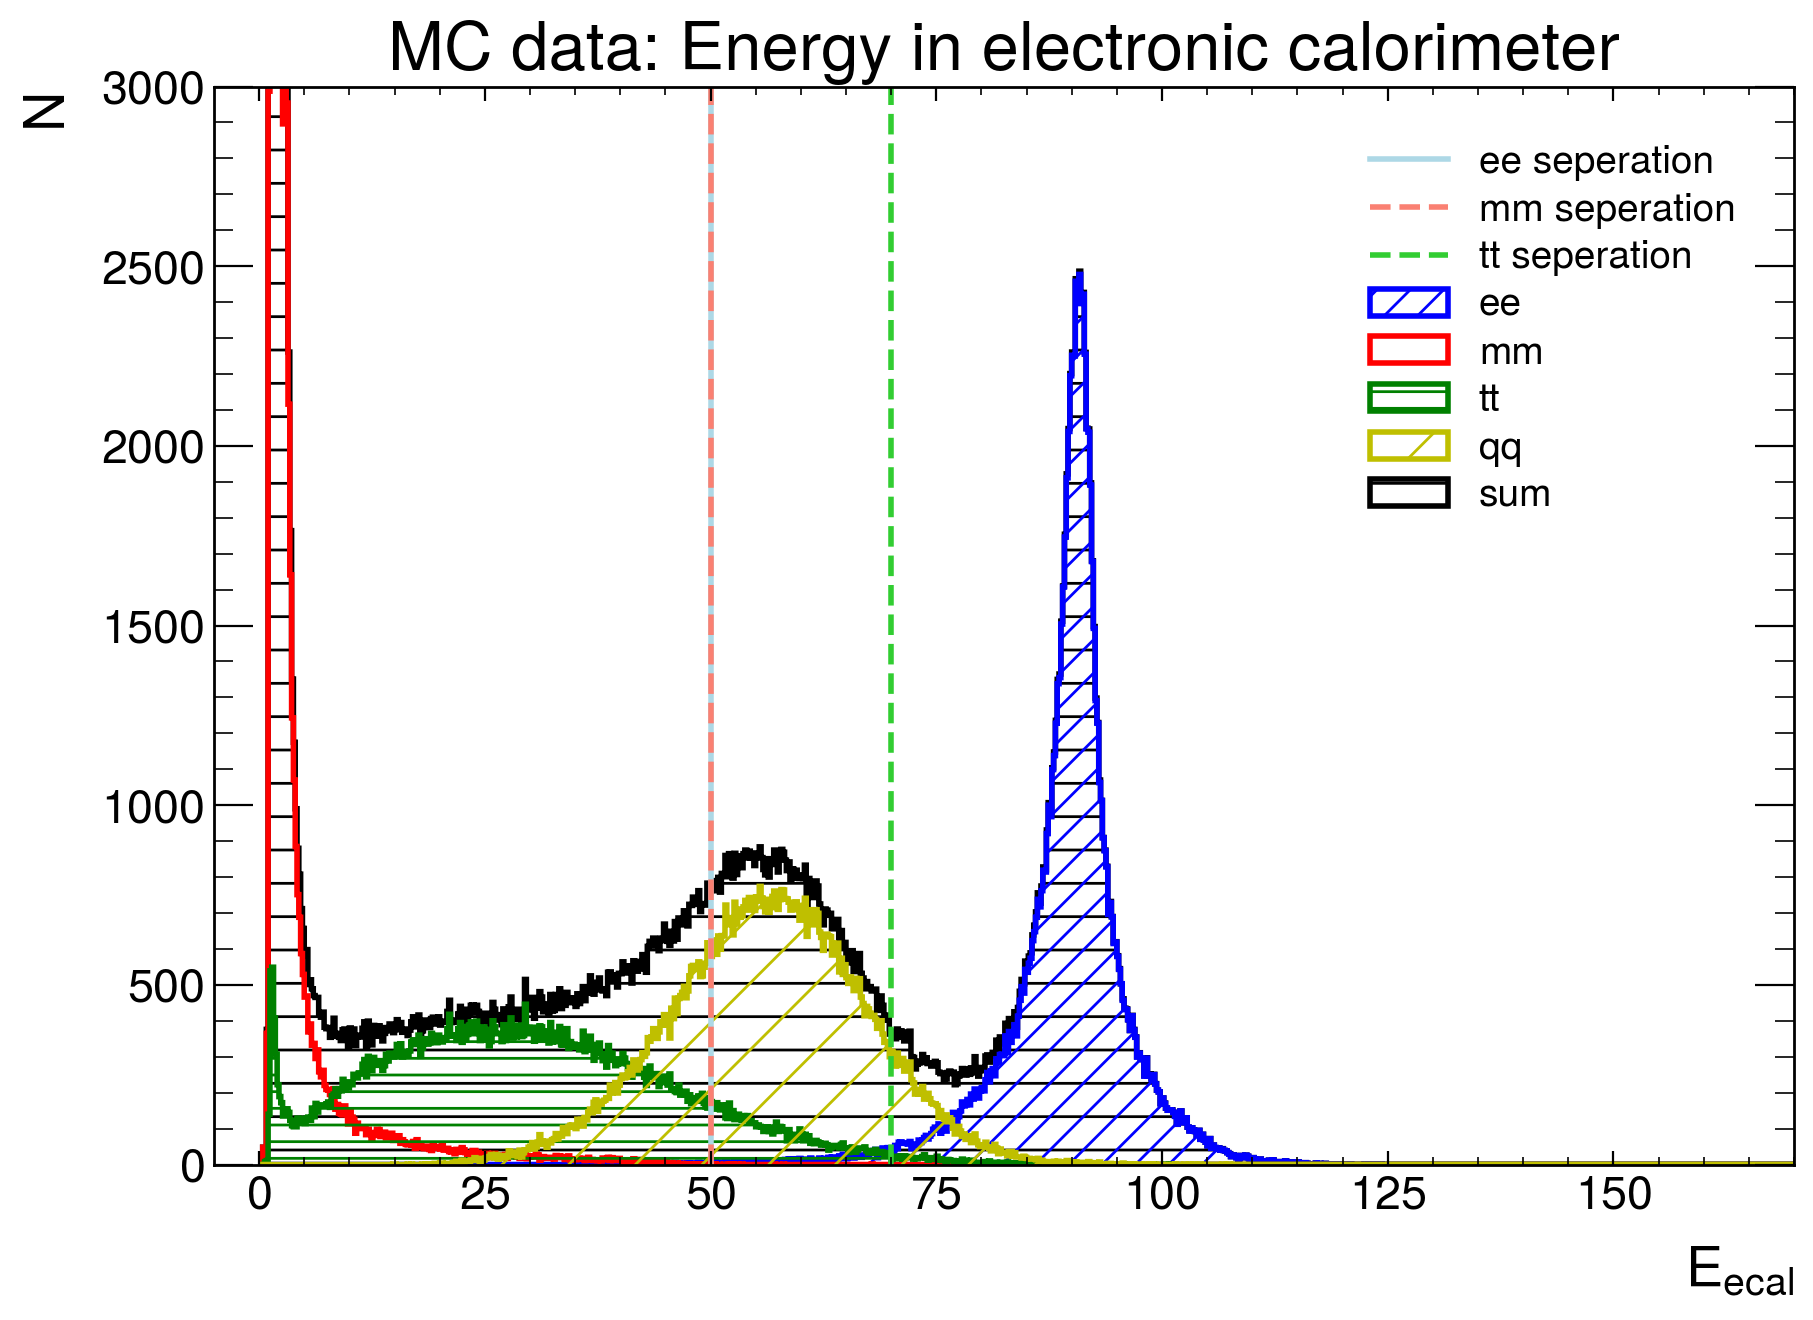

In [8]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=figsize)

bin_content, bin_edges, _ = plt.hist(eecal[0], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor=colors['e'], hatch='//', label='ee')
bin_content, bin_edges, _ = plt.hist(eecal[1], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor=colors['m'], hatch='', label='mm')
bin_content, bin_edges, _ = plt.hist(eecal[2], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor=colors['t'], hatch='--', label='tt')
bin_content, bin_edges, _ = plt.hist(eecal[3], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor=colors['q'], hatch='/', label='qq')
bin_content, bin_edges, _ = plt.hist(eecal[4], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor=colors['mix'], hatch='-', label='sum', zorder=1)

plt.axvline(x=50, color = colors['ecut'], ls = '-', label = 'ee seperation')
#vicualize the seperation cuts
plt.axvline(x=50, color = colors['mcut'], ls = '--', label = 'mm seperation')
plt.axvline(x=70, color = colors['tcut'], ls = '--', label = 'tt seperation')
### Show the plot on screen
plt.legend()
plt.title('MC data: Energy in electronic calorimeter')
plt.xlim(-5.,170)
plt.ylim(0,3e3)
plt.xlabel('$E_{ecal}[GeV/c^2]$')
plt.ylabel('N')
plt.savefig('Plots/MC_E_ecal.svg', bbox_inches='tight')
plt.show()

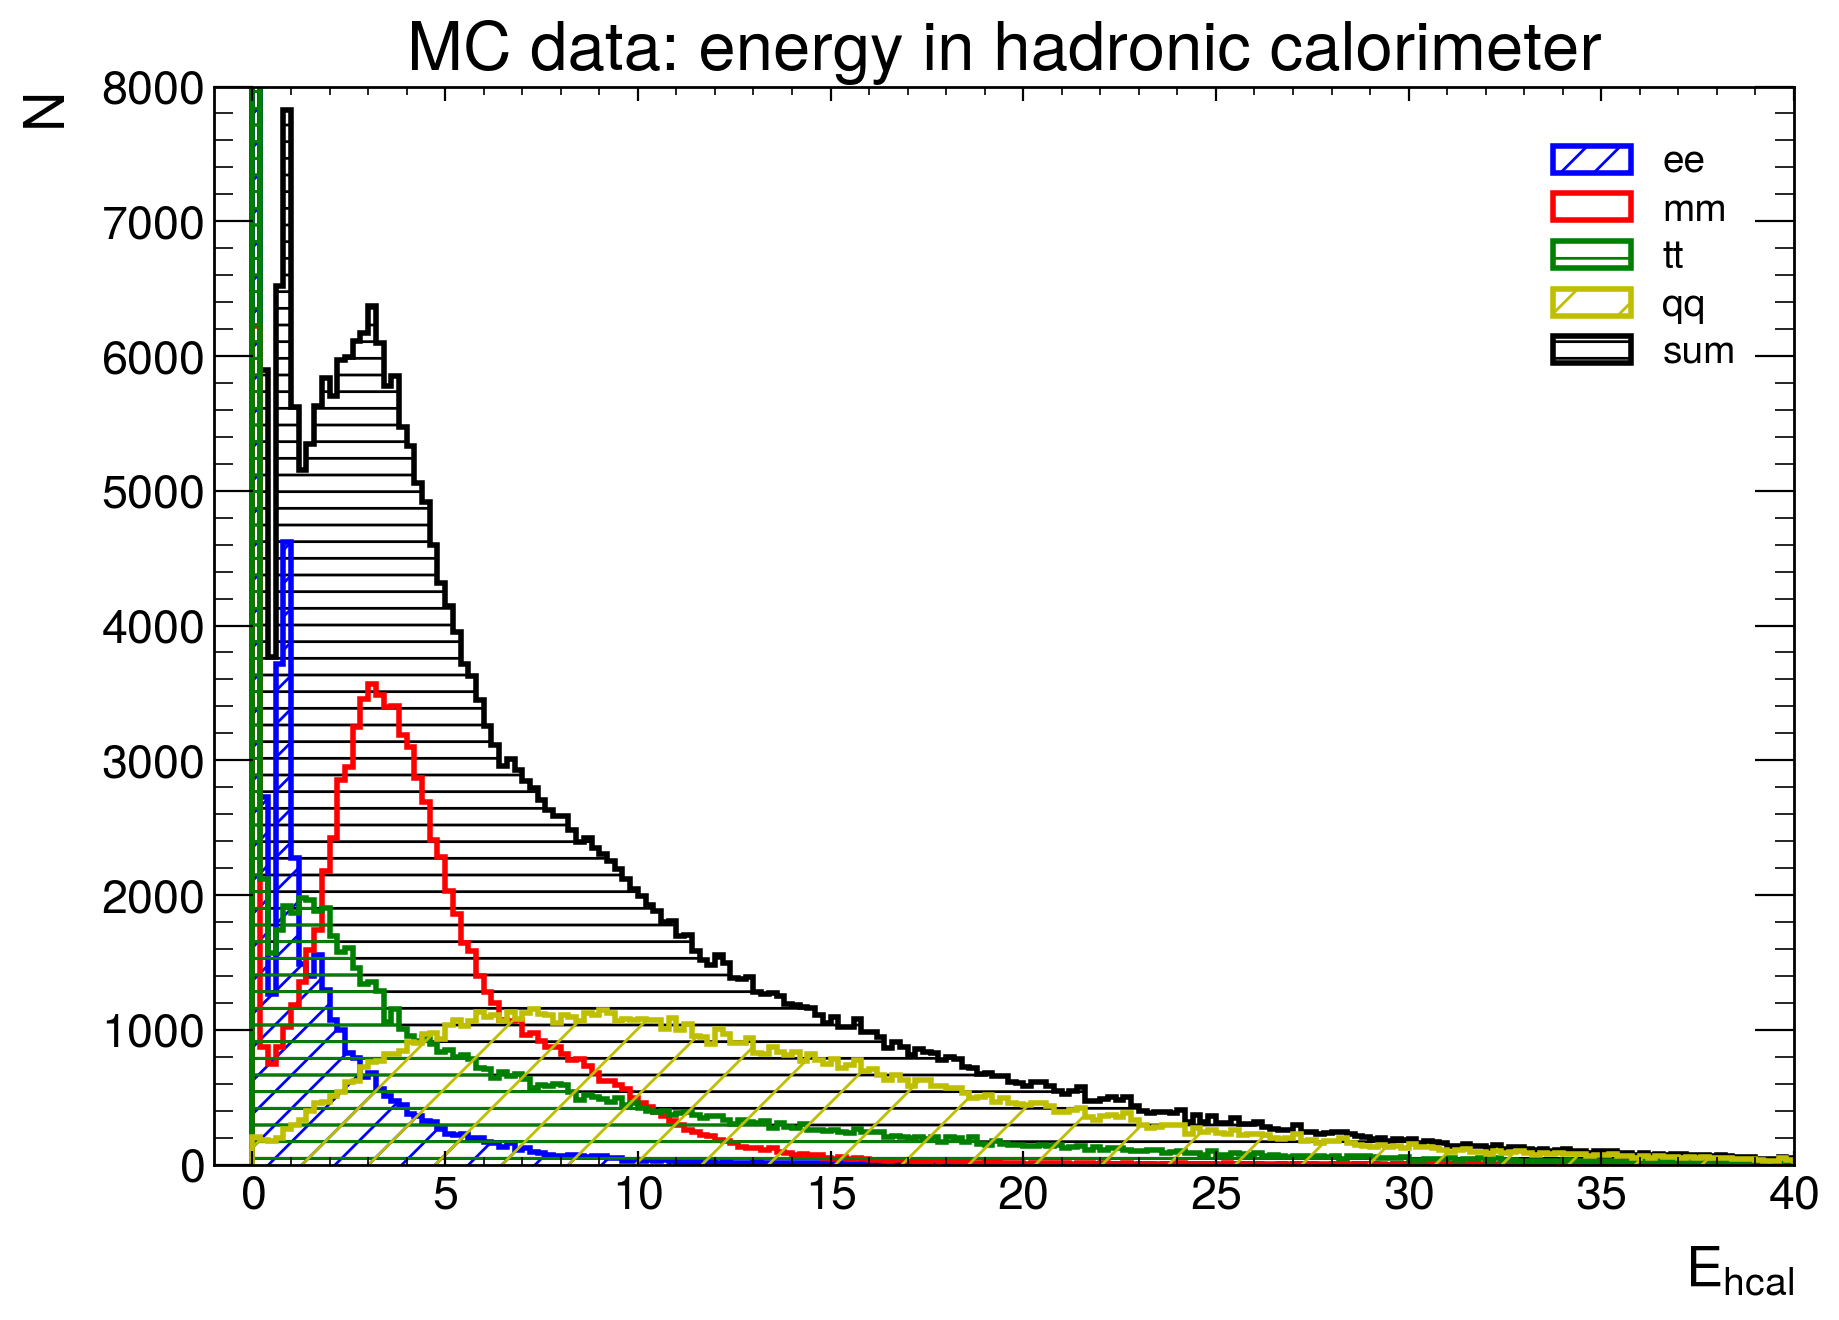

In [9]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=figsize)

bin_content, bin_edges, _ = plt.hist(ehcal[0], bins=200, range=(0.,40.), histtype='step',  linewidth=2, edgecolor=colors['e'], hatch='//', label='ee')
bin_content, bin_edges, _ = plt.hist(ehcal[1], bins=200, range=(0.,40.), histtype='step',  linewidth=2, edgecolor=colors['m'], hatch='', label='mm')
bin_content, bin_edges, _ = plt.hist(ehcal[2], bins=200, range=(0.,40.), histtype='step',  linewidth=2, edgecolor=colors['t'], hatch='--', label='tt')
bin_content, bin_edges, _ = plt.hist(ehcal[3], bins=200, range=(0.,40.), histtype='step',  linewidth=2, edgecolor=colors['q'], hatch='/', label='qq')
bin_content, bin_edges, _ = plt.hist(ehcal[4], bins=200, range=(0.,40.), histtype='step',  linewidth=2, edgecolor=colors['mix'], hatch='--', label='sum', zorder=1)

### Show the plot on screen
plt.legend()
plt.title('MC data: energy in hadronic calorimeter')
plt.xlim(-1,40)
plt.ylim(0,8000)
plt.xlabel('$E_{hcal}[GeV/c^2]$')
plt.ylabel('N')
plt.savefig('Plots/MC_E_hcal.svg', bbox_inches='tight')
plt.show()

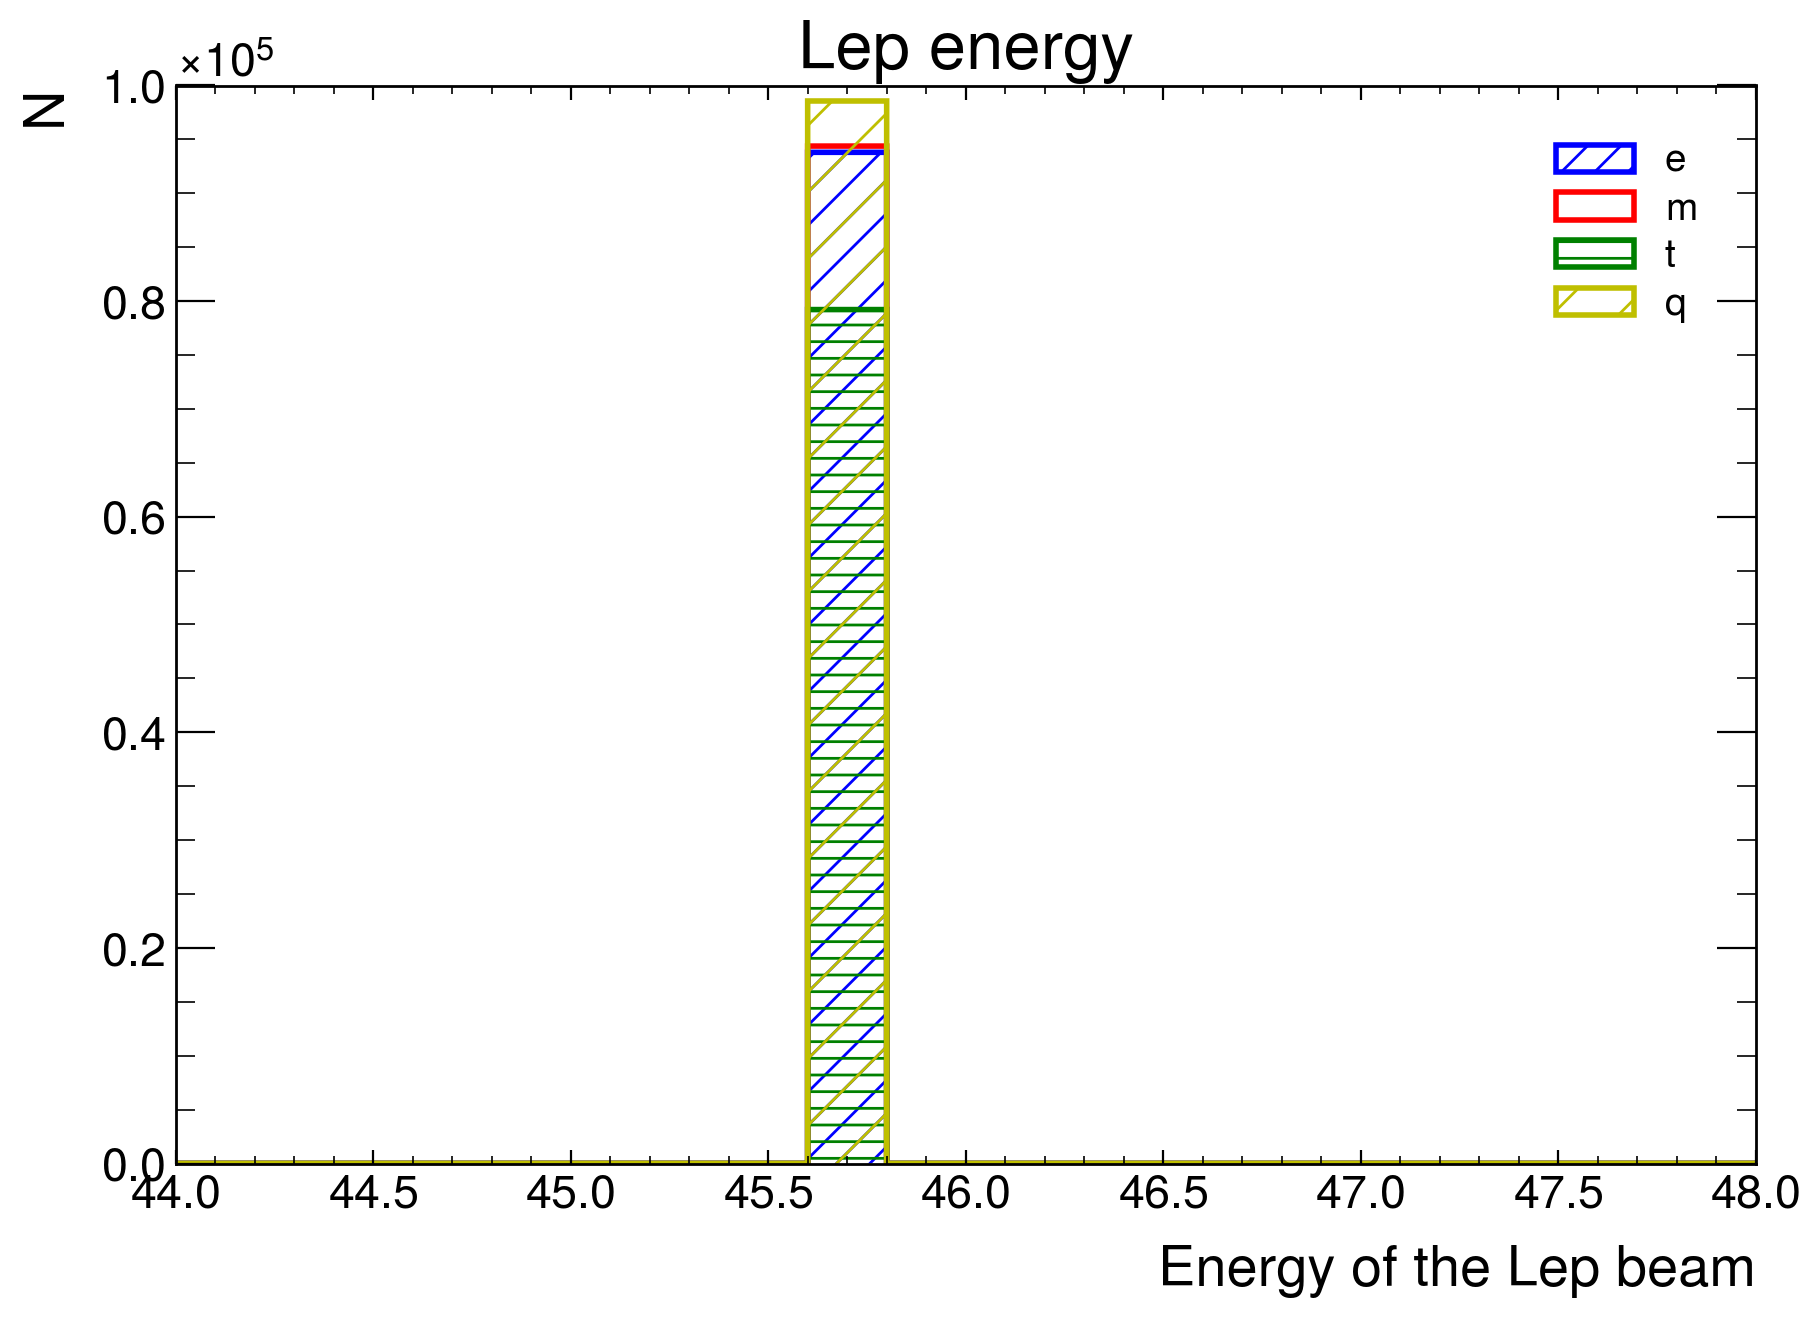

In [10]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=figsize)

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')

bin_content, bin_edges, _ = plt.hist(elep[0], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor=colors['e'], hatch='//', label='e')
bin_content, bin_edges, _ = plt.hist(elep[1], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor=colors['m'], hatch='', label='m')
bin_content, bin_edges, _ = plt.hist(elep[2], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor=colors['t'], hatch='--', label='t')
bin_content, bin_edges, _ = plt.hist(elep[3], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor=colors['q'], hatch='/', label='q')


mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title('Energy of the Lep beam')
plt.xlim(44,48.)
plt.ylim(0,1e5)
plt.xlabel($'E_\text{lep} [GeV/c^2]$')
plt.ylabel('N')
plt.savefig('Plots/MC_E_lep.svg', bbox_inches='tight')
plt.show()

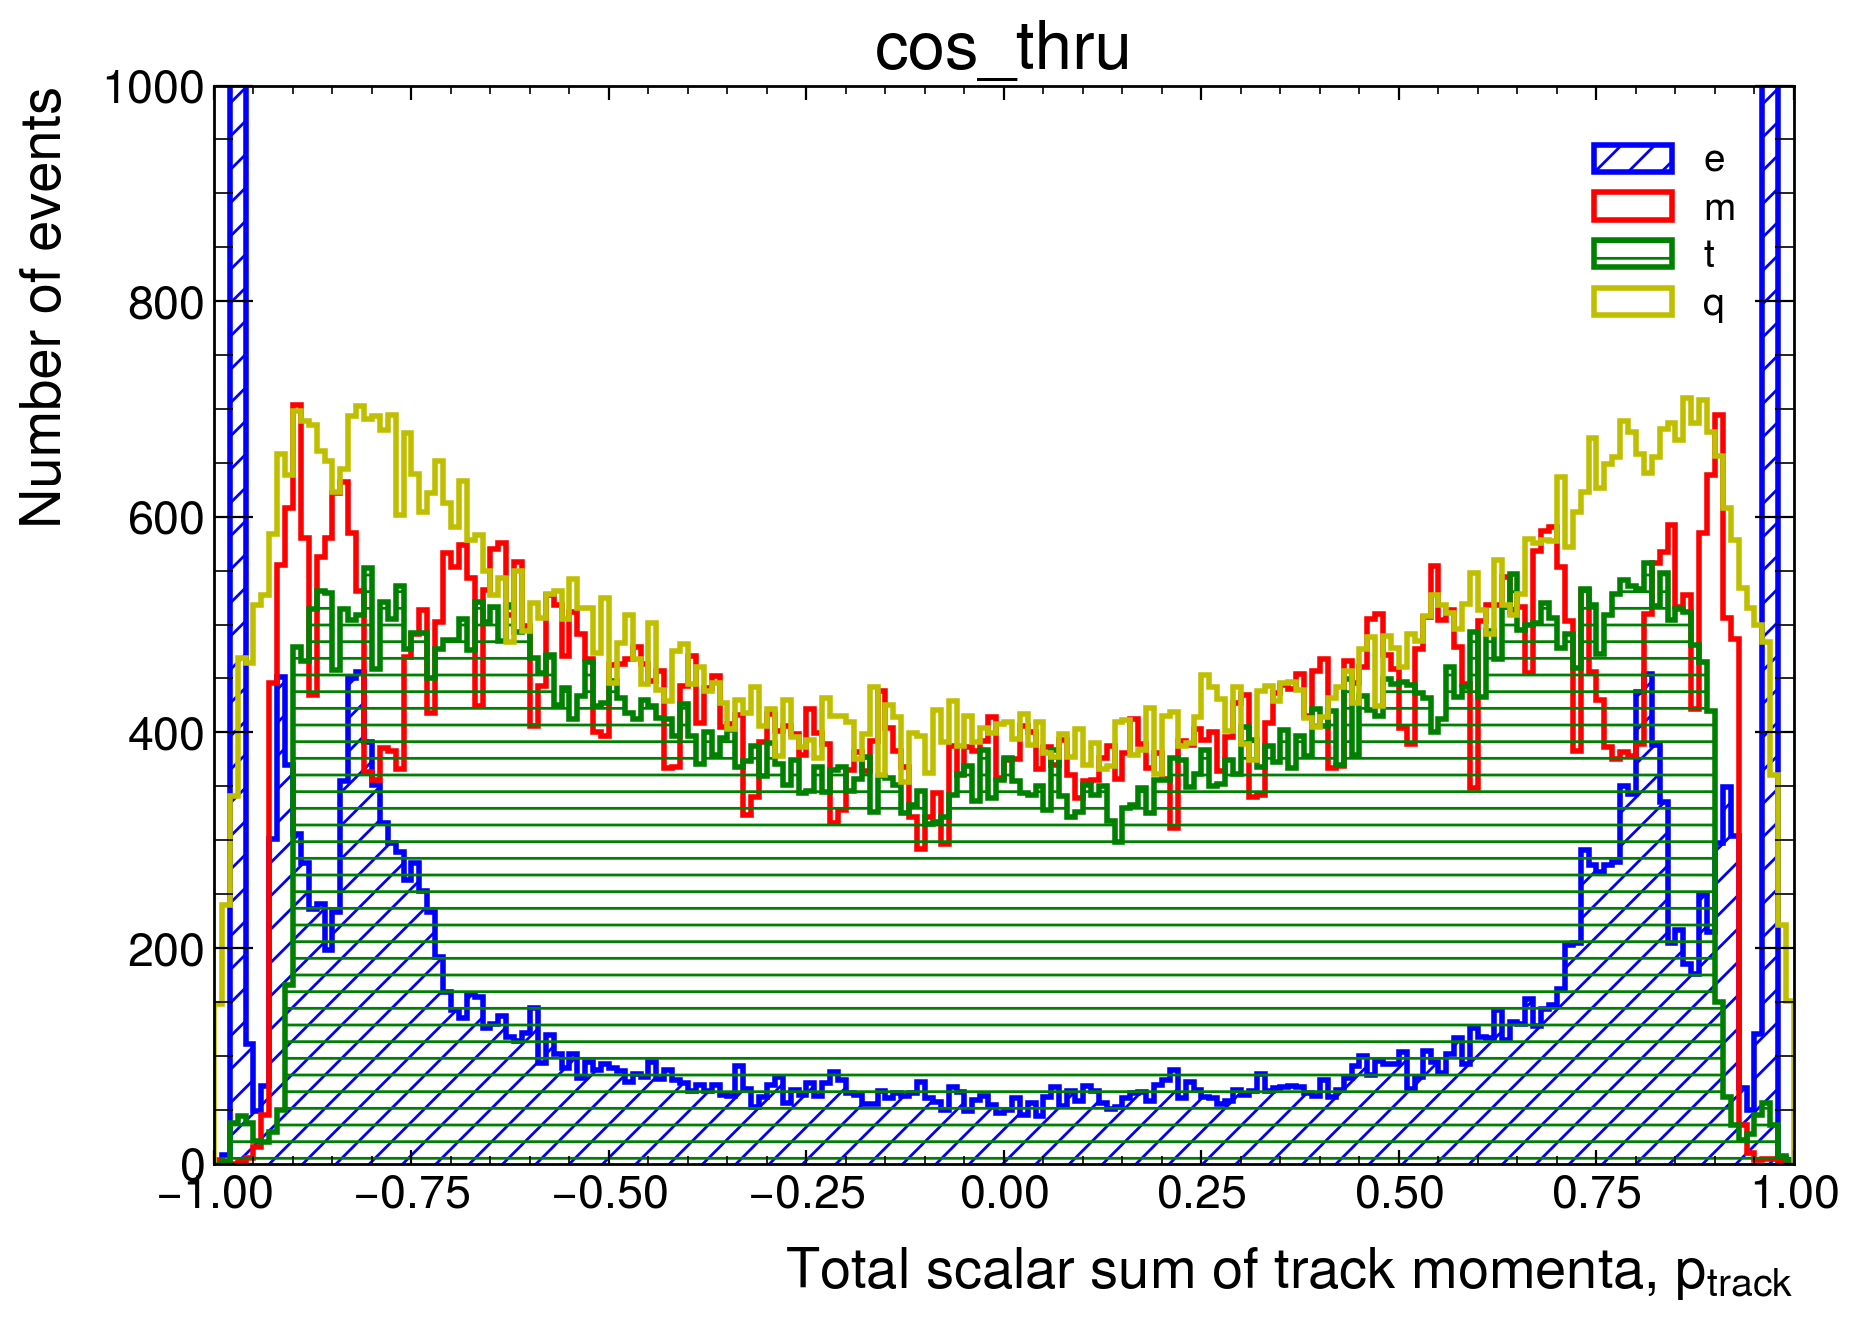

In [11]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=figsize)

bin_content, bin_edges, _ = plt.hist(costhru[0], bins=200, range=(-1,1.), histtype='step',  linewidth=2, edgecolor=colors['e'], hatch='//', label='e')
bin_content, bin_edges, _ = plt.hist(costhru[1], bins=200, range=(-1,1.), histtype='step',  linewidth=2, edgecolor=colors['m'], hatch='', label='m')
bin_content, bin_edges, _ = plt.hist(costhru[2], bins=200, range=(-1,1.), histtype='step',  linewidth=2, edgecolor=colors['t'], hatch='--', label='t')
bin_content, bin_edges, _ = plt.hist(costhru[3], bins=200, range=(-1,1.), histtype='step',  linewidth=2, edgecolor=colors['q'], hatch='', label='q')
#bin_content, bin_edges, _ = plt.hist(costhet[4], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='black', hatch='/', label='sum', zorder=1)


### Show the plot on screen
plt.legend()
plt.title(var[5])
plt.xlim(-1,1)
plt.ylim(0,1000)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')
plt.show()

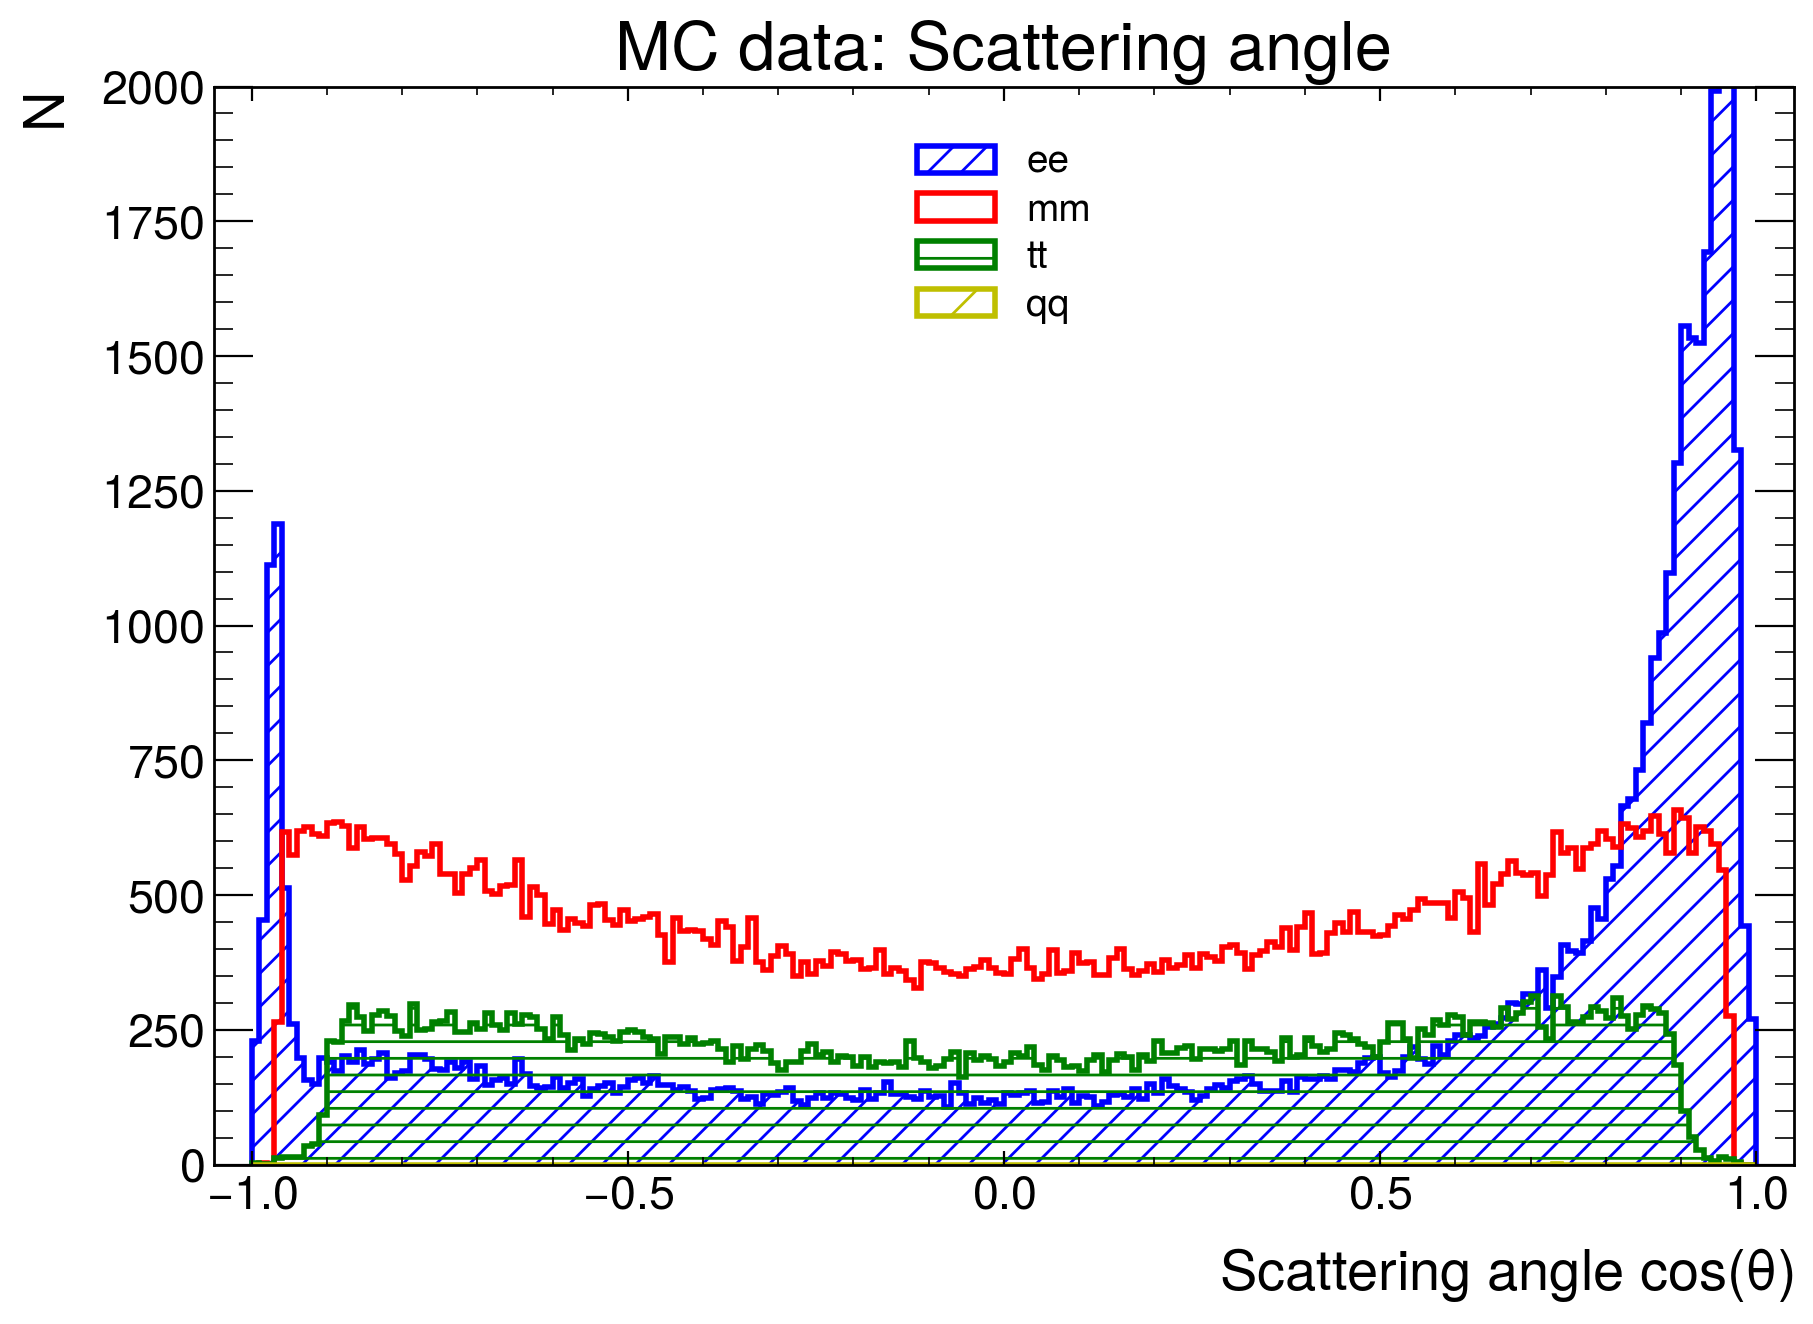

In [12]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=figsize)

x_min =-1
x_max = 1
bin_content, bin_edges, _ = plt.hist(costhet[0], bins=200, range=(x_min,x_max), histtype='step',  linewidth=2, edgecolor=colors['e'], hatch='//', label='ee')
bin_content, bin_edges, _ = plt.hist(costhet[1], bins=200, range=(x_min,x_max), histtype='step',  linewidth=2, edgecolor=colors['m'], hatch='', label='mm')
bin_content, bin_edges, _ = plt.hist(costhet[2], bins=200, range=(x_min,x_max), histtype='step',  linewidth=2, edgecolor=colors['t'], hatch='--', label='tt')
bin_content, bin_edges, _ = plt.hist(costhet[3], bins=200, range=(x_min,x_max), histtype='step',  linewidth=2, edgecolor=colors['q'], hatch='/', label='qq')
#bin_content, bin_edges, _ = plt.hist(costhet[4], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor=colors['mix'], hatch='/', label='sum', zorder=1)
#bin_content, bin_edges, _ = plt.hist(costhet[4], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor=colors['mix'], hatch='/', label='sum', zorder=1)



### Show the plot on screen
plt.legend(loc = 9)
plt.title('MC data: Scattering angle')
plt.xlim(x_min-0.05,x_max+0.05)
plt.ylim(0,2000)
plt.xlabel(r'Scattering angle $cos(\theta)$')
plt.ylabel('N')
plt.show()

# Cut application in MC data and efficiency matrix
Cuts, selected in the Monte Carlo data, to separate the particle classes from each other.

The cutting condition is applied in the "high level array". The resulting masks consit of "True" or "False" entries. Adding up all the created masks for one particle class results in the total cutting mask.

In [13]:
# Cuts, to separate the electrons and find the wrong particles in the electron cut
ecuts = [0] * 6
i = 0
while i < 4: #Index 0 to find the electron and all other indices to find the wrong fermions in the electron cut
    emasks = [0] * 6
    emasks[0] = brancheses[i]['E_ecal'] >= 50 #to separate electrons from muons
    emasks[1] = brancheses[i]['E_ecal'] >= 68 #redundant cut to separate electrons from tauons
    emasks[2] = brancheses[i]['Ncharged'] <= 2  #to separate electrons from Hadrons and eliminate more photon events
    ecuts[i] = emasks[0] & emasks[1] & emasks[2] #combining the masks
    i += 1

    
# Cuts, to separate the muons and find the wrong particles in the muon cut
mcuts = [0] * 6
i = 0
while i < 4: #Index 1 to find the muons and all other indices to find the wrong fermions in the muon cut
    mmasks = [0] * 4
    mmasks[0] = brancheses[i]['E_ecal'] <= 50 #to separate the muons from electrons
    mmasks[1] = brancheses[i]['Pcharged'] >= 75 #to separate the muons from tauons
    mmasks[2] = brancheses[i]['Ncharged'] == 2 #to separate the muons from hadrons
    mcuts[i] = mmasks[0] & mmasks[1] & mmasks[2]
    i += 1

    
tcuts = [0] * 6
i = 0
while i < 4: #Index 2 to find the tauons and all other indices to find the wrong fermions in the tauon cut
    tmasks = [0] * 4
    tmasks[0] = brancheses[i]['E_ecal'] <= 70 #to separate tauons from electrons
    tmasks[1] = brancheses[i]['Pcharged'] <= 73 #to separate tauons from muons
    tmasks[3] = brancheses[i]['Pcharged'] >= 3  #to recalculate the 0 track events
    tmasks[2] = brancheses[i]['Ncharged'] <= 7 #to separate the hadrons
    tcuts[i] =  tmasks[1] & tmasks[2] & tmasks[0] & tmasks[3]
    i += 1

    
qcuts = [0] * 6
i = 0
while i < 4:
    qmasks = [0] * 3
    qmasks[0] = brancheses[i]['Ncharged'] >= 8 #to separate the hadrons
    qmasks[1] = brancheses[i]['Ncharged'] >= 8
    qmasks[2] = brancheses[i]['Ncharged'] >= 8
    qcuts[i] = qmasks[0] & qmasks[1] & qmasks[2]
    i += 1

In [14]:
# Creation of the recalculation matrix A
N = 100000 # Total number of simulated events per fermion class
Ne = N # Number of simulated electron events
Nm = N # Number of simulated muon events
Nt = N # Number of simulated tauon events
Nq = N # Number of simulated hadron events

# Number of events in the events of a fermion class (column) in a fermion chanel (line)
k = np.array([[np.sum(ecuts[0]), np.sum(ecuts[1]), np.sum(ecuts[2]), np.sum(ecuts[3])],
              [np.sum(mcuts[0]), np.sum(mcuts[1]), np.sum(mcuts[2]), np.sum(mcuts[3])],
              [np.sum(tcuts[0]), np.sum(tcuts[1]), np.sum(tcuts[2]), np.sum(tcuts[3])],
              [np.sum(qcuts[0]), np.sum(qcuts[1]), np.sum(qcuts[2]), np.sum(qcuts[3])]
             ])

# Total Number events simulated per fermion class
n = np.array([[Ne,Nm,Nt,Nq],
              [Ne,Nm,Nt,Nq],
              [Ne,Nm,Nt,Nq],
              [Ne,Nm,Nt,Nq]
              ])

# Clalculation the Efficiency Matrix by deviding obverved events by expected events (deviding element not as matrices)
A = k / n

# Applying Bayesian Statistics to determine the Variance (and error with sqrt) of the Efficiency Matrix
A_err = np.sqrt(((k+1)*(k+2)/((n+2)*(n+3))) - ((k+1)**2/(n+2)**2))


print('Efficiency Matrix A:')
print(np.array_repr(A, precision=7, suppress_small=True),'\n')

print('Errors of efficiency Matrix A_err:')
print(np.array_repr(A_err, precision=7, suppress_small=True))

Efficiency Matrix A:
array([[0.81571, 0.00001, 0.00678, 0.     ],
       [0.00015, 0.84071, 0.00284, 0.     ],
       [0.00326, 0.03457, 0.75764, 0.00754],
       [0.00006, 0.     , 0.00544, 0.97548]]) 

Errors of efficiency Matrix A_err:
array([[0.0012261, 0.0000141, 0.0002597, 0.00001  ],
       [0.00004  , 0.0011572, 0.0001686, 0.00001  ],
       [0.0001805, 0.0005778, 0.0013551, 0.0002737],
       [0.0000265, 0.00001  , 0.0002328, 0.0004892]])


In [15]:
A_inv = np.linalg.inv(A)# Matrix inversion of the efficiency Matrix
print('Correction Matrix A_inv, the inverse of the efficiency Matrix')
print(A_inv)

Correction Matrix A_inv, the inverse of the efficiency Matrix
[[ 1.22596965e+00  4.36637690e-04 -1.09732534e-02  8.48180694e-05]
 [-2.00950835e-04  1.18965411e+00 -4.45784631e-03  3.44570480e-05]
 [-5.26551795e-03 -5.42870607e-02  1.32021196e+00 -1.02046153e-02]
 [-4.60427290e-05  3.02718059e-04 -7.36180615e-03  1.02519325e+00]]


Analytical error determination to the inverse Matrix.

The calculation follows the description in:  https://arxiv.org/abs/hep-ex/9909031v1

In [16]:
A_inv_err = np.zeros((4,4)) #Creating the inverse Matrix

#Loops over entries in the inverse matrix and entries of the error matrix.
i = 0
while i < 4:
    j = 0
    while j < 4:
        m = 0
        while m < 4:
            n = 0
            while n < 4:
                A_inv_err[i,j] += (A_inv[i,m] * A_err[m,n] * A_inv[n,j])**2
                n += 1
            m += 4
        A_inv_err[i,j] =  np.sqrt((A_inv_err[i,j]))
        j += 1
    i += 1
print('Errors of the inverse matrix:')
print(A_inv_err)

Errors of the inverse matrix:
[[1.84279761e-03 2.69172409e-05 4.20631852e-04 1.29819117e-05]
 [3.02056187e-07 4.41205216e-09 6.89465045e-08 2.12788791e-09]
 [7.91478312e-06 1.15609074e-07 1.80660636e-06 5.57570812e-08]
 [6.92084268e-08 1.01090857e-09 1.57973229e-08 4.87550930e-10]]


# Cutting in the sum of the MC data

To test the selected cuts, they are applied on the sum of all Monte Carlo data. The summ of all MC data is stored in "brancheses[4]" and the same cuts as above are applied.

In [17]:
i = 4 #Index of the sum of the MC data

#Applying the same cuts as above
emasks = [0] * 3 
emasks[0] = brancheses[i]['E_ecal'] >= 50
emasks[1] = brancheses[i]['E_ecal'] >= 68
emasks[2] = brancheses[i]['Ncharged'] <= 2
ecuts[i] = emasks[0] & emasks[1] & emasks[2] #Total mask after electron cutting


mmasks = [0] * 4
mmasks[0] = brancheses[i]['E_ecal'] <= 50
mmasks[1] = brancheses[i]['Pcharged'] >= 75
mmasks[2] = brancheses[i]['Ncharged'] == 2
mcuts[i] = mmasks[0] & mmasks[1] & mmasks[2] #Total mask after muon cutting


tmasks = [0] * 4
tmasks[0] = brancheses[i]['E_ecal'] <= 70
tmasks[1] = brancheses[i]['Pcharged'] <= 73
tmasks[3] = brancheses[i]['Pcharged'] >= 3
tmasks[2] = brancheses[i]['Ncharged'] <= 7
tcuts[i] =  tmasks[1] & tmasks[2] & tmasks[0] & tmasks[3] #Total mask after tauon cutting


qmasks = [0] * 3
qmasks[0] = brancheses[i]['Ncharged'] >= 8
qmasks[1] = brancheses[i]['Ncharged'] >= 8
qmasks[2] = brancheses[i]['Ncharged'] >= 8
qcuts[i] = qmasks[0] & qmasks[1] & qmasks[2]

In [18]:
# Test wether the recalculation to the total particle numbers after cutting works:

In [19]:
e_tot_cut = np.sum(ecuts[4]) #Number of electrons after cutting (mixed with other particles)
m_tot_cut = np.sum(mcuts[4])
t_tot_cut = np.sum(tcuts[4])
q_tot_cut = np.sum(qcuts[4])

# Dot product of the recalculation Matrix A_inv with the vector of cuttet particles.
B = A_inv.dot(np.array([e_tot_cut, m_tot_cut, t_tot_cut, q_tot_cut]) )

print('Recalculated particle numbers:')
print('Total number of electrons: {0:6.0f}, muons: {1:6.0f}, tauons {3:6.0f} and hadrons: {4:6.0f}' .format(B[0],B[1],B[1],B[2],B[3]))
print('Check, total number is matching!')

Recalculated particle numbers:
Total number of electrons: 100000, muons: 100000, tauons 100000 and hadrons: 100000


Check, total number is matching!


# Exercise 2: Separate $t$- and $s$-channel contributions

Only Feynman diagrams contributing to the production of $Z$ boson are to be considered for the measurements. The **electron** Monte Carlo sample incorporate contributions from $t$- and $s$-channels.
* Select/correct contributions producing $Z$ boson decays. (Hint: Which role does the $\cos(\theta)$ distribution play in separating $t$- and $s$-channels?)

As an example this seperation is done in the MC total data, to demonstrate how it is done later on with the measured data. 

In [20]:
Nbins = 200
# Cutting the electrons out of the total MC data
electrons_cut =costhet[4][ecuts[4]] 
# The electrons are not corrected, cause this correction is only done for the summ of all scatterd electrons. Not bin wise for the scattered electrons depending on the angle.
# Histogramming the cos(theta) data
e_cut, bin_edges, = np.histogram(electrons_cut, bins=Nbins, range=(-1,1))
mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) # Finding the mid between the bins on the x axis.

<ipython-input-20-961ea420f56d>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  electrons_cut =costhet[4][ecuts[4]]


In [21]:
# Define fit function. 
# The fit funciton consists of two parts. One for the s-channel and one for the t-channel

In [22]:
def dsigdtheta(theta,A,B):
    '''Total fit function to separate s- and t-channel. 
    First part with the scaling parameter A for the s-channel and the second part with the scaling parameter B for the t-channel.
    
    Args:
        A (float): Scaling for the s-channel
        B (float): Scaling for the t-channel
    '''
    y = A*(1+theta**2)+B*(1-theta)**(-2)
    return y
def sdsig(theta,A):
    '''Representation of the s-channel. With the scaling parameter A
    
    Args:
        A (float): Scaling for the s-channel
    '''
    return A*(1+theta**2)
def tdsig(theta,B):
    '''Representation of the t-channel. With the scaling parameter B
    
    Args:
        B (float): Scaling for the t-channel
    '''
    return B*(1-theta)**(-2)

In [23]:
def chi2(data, fit, err_data,ndf):
    '''Calculation of chisquare over ndf.
    
    Args: 
        data: Measured data points
        fit: fit data points
        err_data: Errors on the measured data points
        ndf: Number of degree of freedom (number of data points - fit parameter)
    '''
    chisquare = sum((data-fit)**2/err_data**2)
    return chisquare/ndf

In [26]:
sum((hist_fit- e_cut[bin_min:bin_max])**2)

130568.2030621221

Ratio of the s part between -1 and 1 of the total counts:0.544 +- 0.005


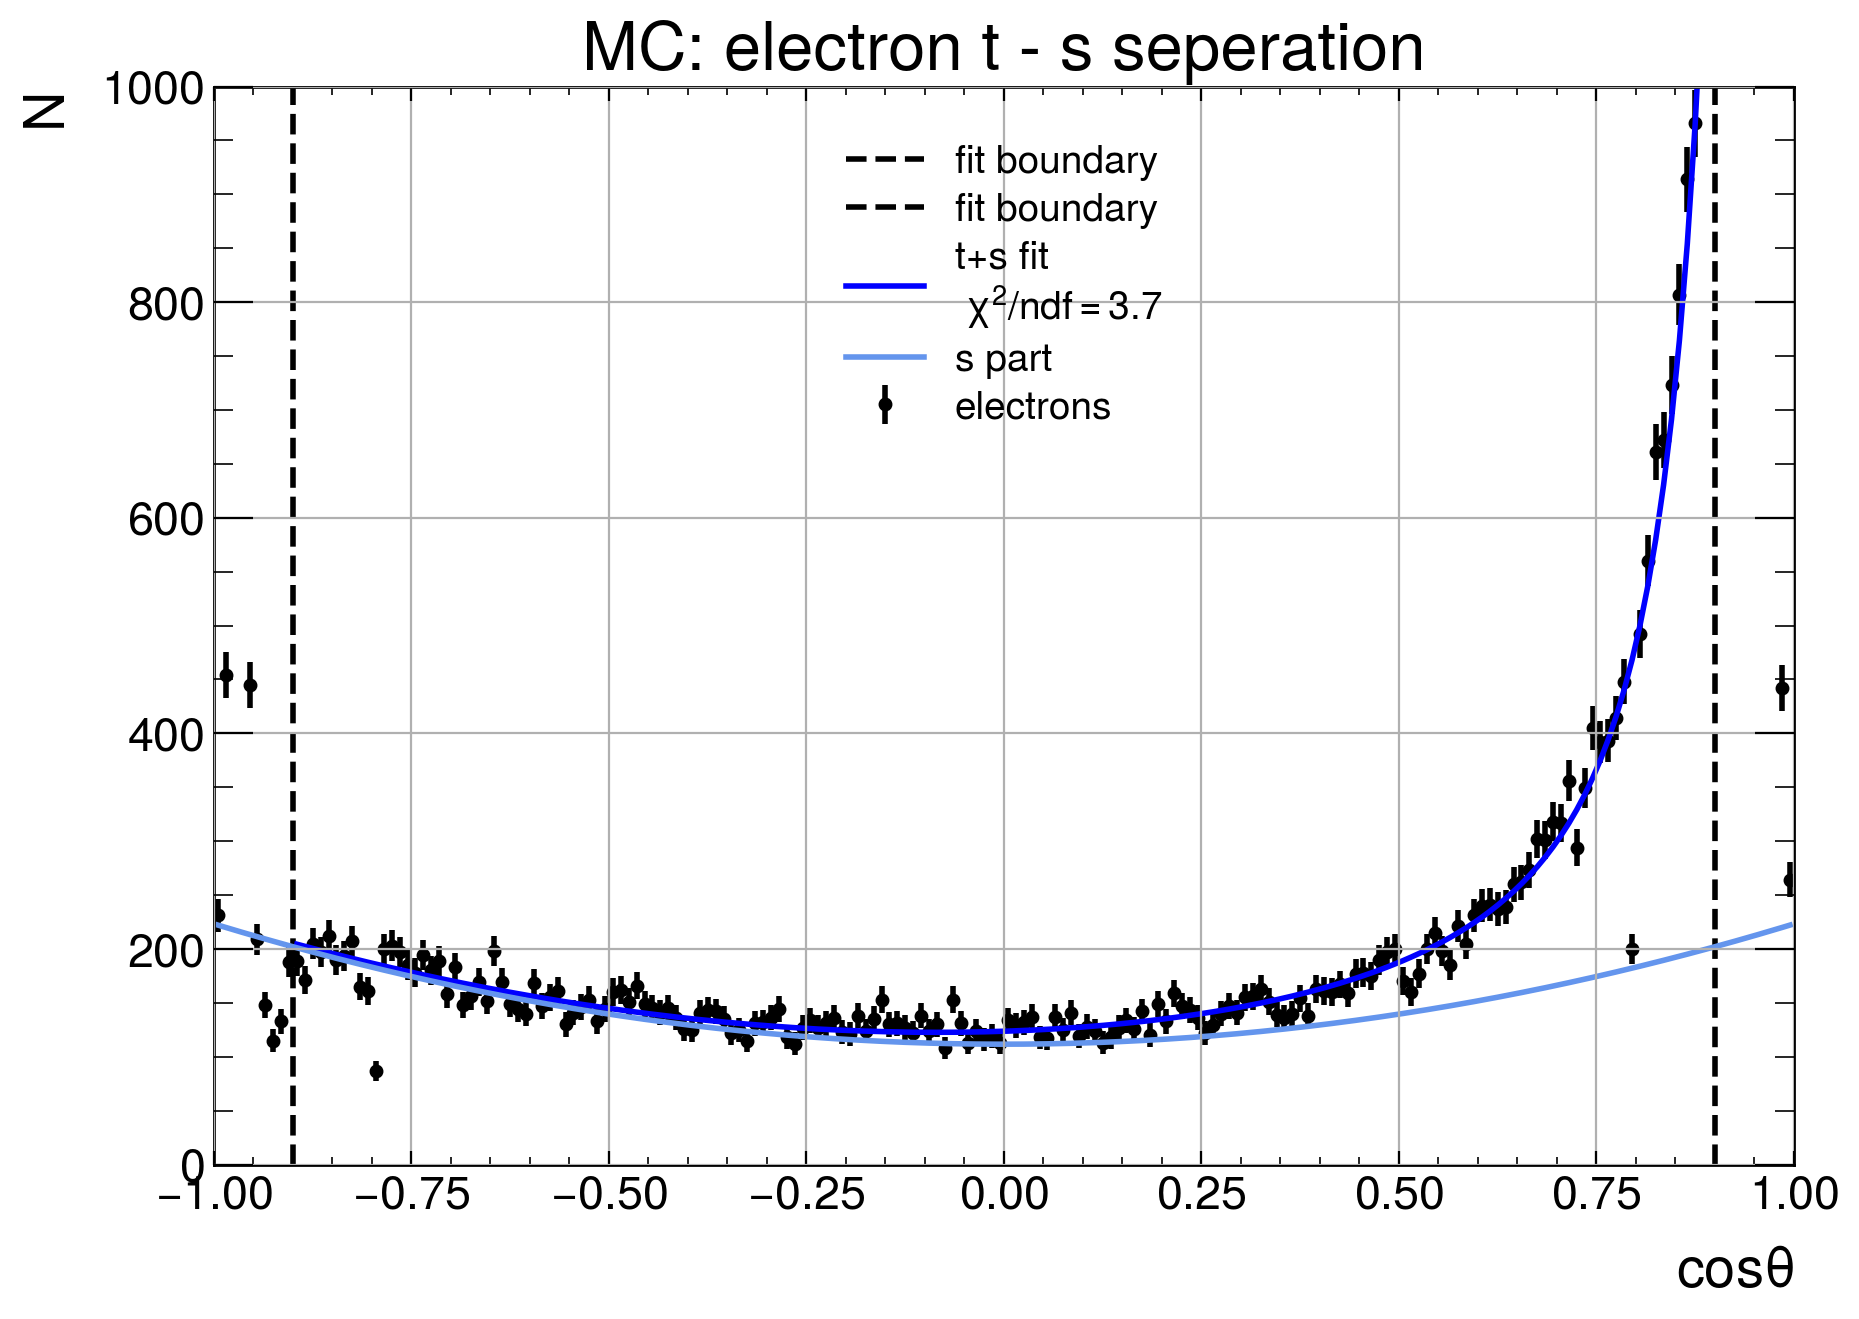

180


In [25]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=figsize)

# Subtracting t channel
bin_min = 10
bin_max = int(950/5)
x_min = mid[bin_min]
x_max = mid[bin_max]
x_min_e_cut = x_min
x_max_e_cut = x_max

coeff, var_matrix  =curve_fit(dsigdtheta,mid[bin_min:bin_max],e_cut[bin_min:bin_max])
hist_fit = dsigdtheta(mid[bin_min:bin_max],*coeff)
fit_s_chan = sdsig(mid,coeff[0])

#Analytical integral of the s channal betweenn -1 and 1 devided by the total number of electrons
s_partial = coeff[0] * (8 / 3) * len(fit_s_chan) / (sum(e_cut)*2) 

#Gaussian error clalculation
N_err = np.sqrt(sum(e_cut))
s_partial_err =np.sqrt(((8 / 3) * (len(fit_s_chan) / (sum(e_cut)*2))**2) * var_matrix[0][0] + (coeff[0] * (8 / 3) * len(fit_s_chan) / (sum(e_cut)*2)**2 )**2 * N_err**2)   
print('Ratio of the s part between -1 and 1 of the total counts:{:1.3f} +- {:1.3f}'.format(s_partial, s_partial_err) )
e_cut_err = np.sqrt(e_cut)
chi_mc = chi2(e_cut[bin_min:bin_max],hist_fit,e_cut_err[bin_min:bin_max],len(e_cut_err[bin_min:bin_max])-2)



plt.title('MC: electron t - s seperation')
plt.errorbar(mid, e_cut, yerr=e_cut_err, label = 'electrons', fmt=".", color=colors['mix'], zorder=1)
#plt.plot(mid, e_cut, label = 'electrons', color=colors['e'])
plt.axvline(x=0.9, color = 'k', ls = '--', label = 'fit boundary')
plt.axvline(x=-0.9, color = 'k', ls = '--', label = 'fit boundary')

plt.plot(mid[bin_min:bin_max],hist_fit,label = 't+s fit \n $\chi^2/ndf = {:1.2}$'.format(chi_mc),color = colors['e'] )
plt.plot(mid,fit_s_chan, label = 's part', color = colors['es'])
plt.xlabel(r'$cos{\theta}$')
plt.ylabel('N')
plt.grid()
plt.ylim(0,1000)
plt.legend()
plt.savefig('Plots/MC_s_seperation.svg', bbox_inches = 'tight')
plt.show()
print(len(e_cut_err[bin_min:bin_max]))

As it is done here for the MC data, the t and s seperation is done in the measurement for each energy

# Exercise 3: Measurement of the total production cross sections

For **each** of the seven centre-of-mass energies:
* Determine the number of events in the handronic channel *and* in the three leptonic channels
* Substract the background and correct for selection efficiencies accordingly
* Then, calculate the differnetial cross sections for the hadronic *and* the leptnic channels
* Add the radiation corrections from The table given below. **Don't forget to take the uncertainties (errors) into account!**

| $\sqrt{s}$   \[GeV\]| Correction hadronic channel    \[nb\] |  Correction leptonic channel   \[nb\]|
| --- | --- | --- |
| 88.47 | +2.0  | +0.09 |
| 89.46 | +4.3  | +0.20 |
| 90.22 | +7.7  | +0.36 |
| 91.22 | +10.8 | +0.52 |
| 91.97 | +4.7  | +0.22 |
| 92.96 | -0.2  | -0.01 |
| 93.76 | -1.6  | -0.08 |

Feel free to access these values using the dictionary 'xs_corrections' given below.
* Once the total cross section for all four decay channels at all seven energies have been measured, fit a **Breit-Wigner distribution** to measure the $Z$ boson mass ($m_Z$) and the resonance width ($\Gamma_Z$) and the peak cross section s of the resonance for the hadronic and the leptonic channels. Again, **propagate the uncertainties carefully**.
* Compare your results to the OPAL cross section s and the theoretical predictions. How many degrees of freedom does the fit have? How can you udge if the model is compatible with the measured data? Calculate the  **confidence levels**.
* Calculate the partial widths for all channels from the measured cross sections on the peak. Which is the best partial width to start with? Compare them with the theoretical predictions and the values that you have calculated in the beginning.
* Determine from your results the **number of generations of light neutrinos**. Which assumptions are necessary?
* Discuss in detail the systematic uncertainties in the whole procedure of the analysis. Which assumptions were necessary?

These are some **references** that might be interesting to look up:
* Particle Data Book: https://pdg.lbl.gov/2020/download/Prog.Theor.Exp.Phys.2020.083C01.pdf
** Resonances: https://pdg.lbl.gov/2017/reviews/rpp2017-rev-resonances.pdf
* Precision Electroweak Measurements on the Z Resonance (Combination LEP): https://arxiv.org/abs/hep-ex/0509008
* Measurement of the $Z^0$ mass and width with the OPAL detector at LEP: https://doi.org/10.1016/0370-2693(89)90705-3
* Measurement of the $Z^0$ line shape parameters and the electroweak couplings of charged leptons: https://inspirehep.net/literature/315269
* The OPAL Collaboration, *Precise Determination of the $Z$ Resonance Parameters at LEP: "Zedometry"*: https://arxiv.org/abs/hep-ex/0012018
* Fitting a Breit-Wigner curve using uproot: https://masonproffitt.github.io/uproot-tutorial/07-fitting/index.html

In [23]:
xs_corrections = { 'energy' : [ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76] ,
                   'hadronic' : [2.0, 4.3, 7.7, 10.8, 4.7, -0.2, -1.6],
                   'leptonic' : [0.09, 0.20, 0.36, 0.52, 0.22, -0.01, -0.08]}

In [24]:
#Import Opal data
data_nr = 1 #selected data set 

path_opal = 'opal_data/data/daten_' +str(data_nr) +'.root' #File path
data = uproot.open(path_opal) #import data


branchesopal = data[ttree_name].arrays() #write "high level" array

ncharesopal = ak.to_numpy(branchesopal[var[0]]) #copy from strange array to nomal array.
pcharesopal = ak.to_numpy(branchesopal[var[1]])
eecalopal = ak.to_numpy(branchesopal[var[2]])
ehcalopal = ak.to_numpy(branchesopal[var[3]])
elepopal = ak.to_numpy(branchesopal[var[4]])
costhruopal = ak.to_numpy(branchesopal[var[5]])
costhetopal = ak.to_numpy(branchesopal[var[6]])
runopal = ak.to_numpy(branchesopal[var[7]])
eventopal = ak.to_numpy(branchesopal[var[8]])

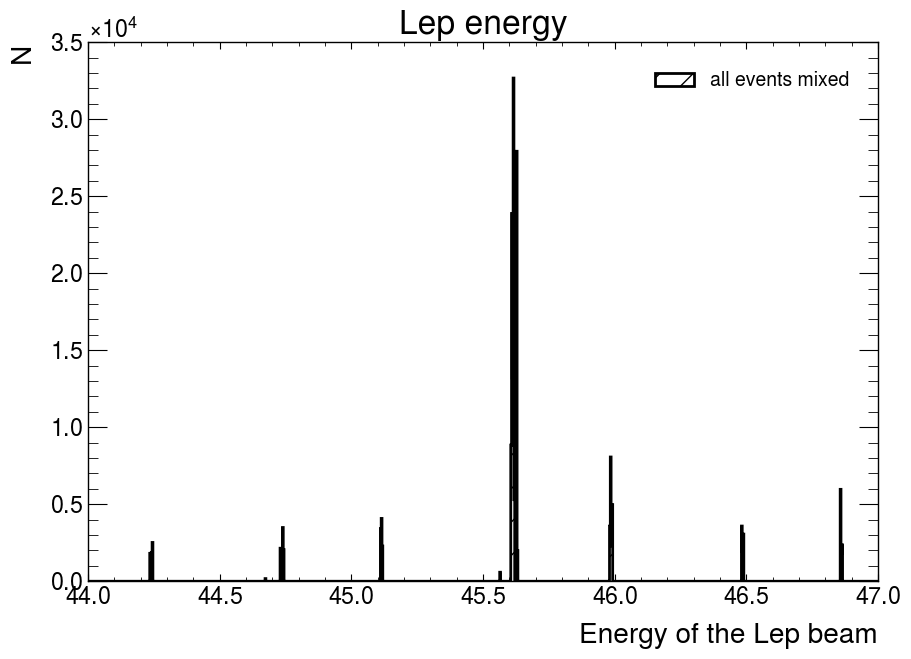

In [25]:
# Plot all OPAL data over the beam energy
plt.style.use(mplhep.style.ATLAS)
plt.figure(figsize=figsize)

bin_content, bin_edges, _ = plt.hist(elepopal, bins=1000, range=(44.,47.), histtype='step',  linewidth=2, edgecolor=colors['mix'], hatch='/', label='all events mixed', color=colors['mix'])

plt.legend()
plt.title('Lep energy')
plt.xlim(44.,47)
plt.xlabel('Energy of the Lep beam')
plt.ylabel('N')
plt.show()

Applying the previously determined cuts on the Opal data, to separate the particles.

In [26]:
opalEcuts = [0] * 7 #Dummy for cutted electrons
opalMcuts = [0] * 7 #Dummy for cutted muons
opalTcuts = [0] * 7 #Dummy for cutted tauons
opalQcuts = [0] * 7 #Dummy for cutted hadrons

#Creation of an additional cut, to separate the energies.
# The cut boundaries are read out from the plot above.
EnergyCutsUP = [44.4, 44.9, 45.2, 45.8, 46.1, 46.6, 47.0]
EnergyCutsLP = [44.0, 44.6, 45.0, 45.4, 45.9, 46.4, 46.8]

# Cutting the Opal data as done for the MC data, with an additional energy cut
#Electrons
i = 0
while i < 7: #Loop over all beam energies
    emasks = [0] * 5
    emasks[0] = branchesopal['E_ecal'] >= 50
    emasks[1] = branchesopal['E_ecal'] >= 68
    emasks[2] = branchesopal['Ncharged'] <=2
    #Energy cut
    emasks[3] = branchesopal['E_lep'] >= EnergyCutsLP[i]
    emasks[4] = branchesopal['E_lep'] <= EnergyCutsUP[i]
    opalEcuts[i] = emasks[0] & emasks[1] & emasks[2] & emasks[3] & emasks[4]
    i += 1

#Muons
i = 0
while i < 7:
    mmasks = [0] * 5
    mmasks[0] = branchesopal['E_ecal'] <= 20
    mmasks[1] = branchesopal['Pcharged'] >= 75
    mmasks[2] = branchesopal['Ncharged'] <=2
    #Energy
    mmasks[3] = branchesopal['E_lep'] >= EnergyCutsLP[i]
    mmasks[4] = branchesopal['E_lep'] <= EnergyCutsUP[i]
    
    opalMcuts[i] = mmasks[0] & mmasks[1] & mmasks[2] & mmasks[3] & mmasks[4] 
    i += 1

#Tauons
i = 0
while i < 7:
    tmasks = [0] * 6
    tmasks[0] = branchesopal['E_ecal'] <= 70
    tmasks[1] = branchesopal['Pcharged'] <= 73
    tmasks[5] = branchesopal['Pcharged'] >= 3 #tauon optimierung
    tmasks[2] = branchesopal['Ncharged'] <= 7
    #Energy
    tmasks[3] = branchesopal['E_lep'] >= EnergyCutsLP[i]
    tmasks[4] = branchesopal['E_lep'] <= EnergyCutsUP[i]

    opalTcuts[i] =  tmasks[1] & tmasks[2] & tmasks[0] & tmasks[3] & tmasks[4] & tmasks[5]
    i += 1

# Hadrons
i = 0
while i < 7:
    qmasks = [0] * 5
    qmasks[0] = branchesopal['Ncharged'] >= 8
    qmasks[1] = branchesopal['Ncharged'] >= 8
    qmasks[2] = branchesopal['Ncharged'] >= 8
    #Energy
    qmasks[3] = branchesopal['E_lep'] >= EnergyCutsLP[i]
    qmasks[4] = branchesopal['E_lep'] <= EnergyCutsUP[i]
    opalQcuts[i] = qmasks[0] & qmasks[1] & qmasks[2] & qmasks[3] & qmasks[4]
    i += 1

In [27]:
# Rescaling the measured chenals acorddin to the efficiency matrix
opalB = [0] * 7
f = [0] * 7
f_err = [0] * 7

i = 0
while i < 7:
    f[i] = np.array([np.sum(opalEcuts[i]), np.sum(opalMcuts[i]), np.sum(opalTcuts[i]), np.sum(opalQcuts[i])])# Vector of measured data in each chenal
    f_err[i] = np.array([np.sqrt(f[i][0]), np.sqrt(f[i][1]), np.sqrt(f[i][2]), np.sqrt(f[i][3])])# Error on the measurement vector
    opalB[i] = A_inv.dot(f[i])# Using the above opained efficiency matrix to rescale the measured chenals
    i += 1

opalB_err = [0] * 7

# Calculating the errors for the rescaled chenals
k = 0
while k < 7:# loop over all lep energies
    opalB_err[k] = [0] * 4
    i = 0
    while i < 4:# loop over all chenals (types of fermions)
        j = 0
        while j < 4:# loop over other (not exluding i) chenals
            # to get the error for the index i a sum over j is pervormed
            opalB_err[k][i] += (A_inv[i,j]**2 * f_err[k][j]**2 + A_inv_err[i,j]**2 * f[k][j]**2)
            j += 1
        opalB_err[k][i] = np.sqrt(opalB_err[k][i])
        i += 1
    k += 1

# Printing all rescaled event counts
tpye = ['ee', 'mm', 'tt', 'qq']
for ii in range(7):
    print('\nEnergy of LEP E = {:4.2f}:'.format(xs_corrections['energy'][ii]))
    for jj in range(4):
        print('Number of {} events = {:4.0f} +- {:4.0f}'.format(tpye[jj], opalB[ii][jj], opalB_err[ii][jj]))


Energy of LEP E = 88.47:
Number of ee events = 2157 +-   52
Number of mm events =  152 +-   14
Number of tt events =  216 +-   19
Number of qq events = 3615 +-   61

Energy of LEP E = 89.46:
Number of ee events = 1922 +-   49
Number of mm events =  276 +-   18
Number of tt events =  279 +-   22
Number of qq events = 5454 +-   75

Energy of LEP E = 90.22:
Number of ee events = 1499 +-   43
Number of mm events =  391 +-   22
Number of tt events =  334 +-   24
Number of qq events = 7730 +-   89

Energy of LEP E = 91.22:
Number of ee events = 12301 +-  124
Number of mm events = 4516 +-   73
Number of tt events = 4753 +-   89
Number of qq events = 95071 +-  312

Energy of LEP E = 91.97:
Number of ee events = 2058 +-   50
Number of mm events =  800 +-   31
Number of tt events =  796 +-   36
Number of qq events = 15674 +-  127

Energy of LEP E = 92.96:
Number of ee events = 1228 +-   39
Number of mm events =  309 +-   19
Number of tt events =  366 +-   24
Number of qq events = 6809 +-   84



* Import Luminosities

In [28]:
lumi_data = 'opal_data/lumi_files/daten_' +str(data_nr) +'.lum' #File path


energy = np.zeros(7) #beam energies
lumi = np.zeros(7) #luminosity
err_all_lumi = np.zeros(7)

with open(lumi_data, newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for jj,row in enumerate(spamreader):
        if jj >0:
            energy[jj-1] = float(row[0])
            lumi[jj-1] = float(row[1])
            err_all_lumi[jj-1] = float(row[4])

* t and s seperation for electron

In [29]:
opal_e_cut_E = []
opal_e_cut_mid = []
Nbins_opal = 30
for i in range(7):
    E, bin_edge, = np.histogram(costhetopal[opalEcuts[i]], bins=Nbins_opal, range=(-1,1))
    mid = 0.5*(bin_edge[1:] + bin_edge[:-1])

    opal_e_cut_E.append(E)
    opal_e_cut_mid.append(mid)


In [30]:
def chi2(data, fit, err_data,ndf):
    '''Calculation of chisquare over ndf.
    
    Args: 
        data: Measured data points
        fit: fit data points
        err_data: Errors on the measured data points
        ndf: Number of degree of freedom (number of data points - fit parameter)
    '''
    chisquare = sum((data-fit)**2/err_data**2)
    return chisquare/ndf

Range for fitting: cos(theta)= -0.8333334 to 0.8333334


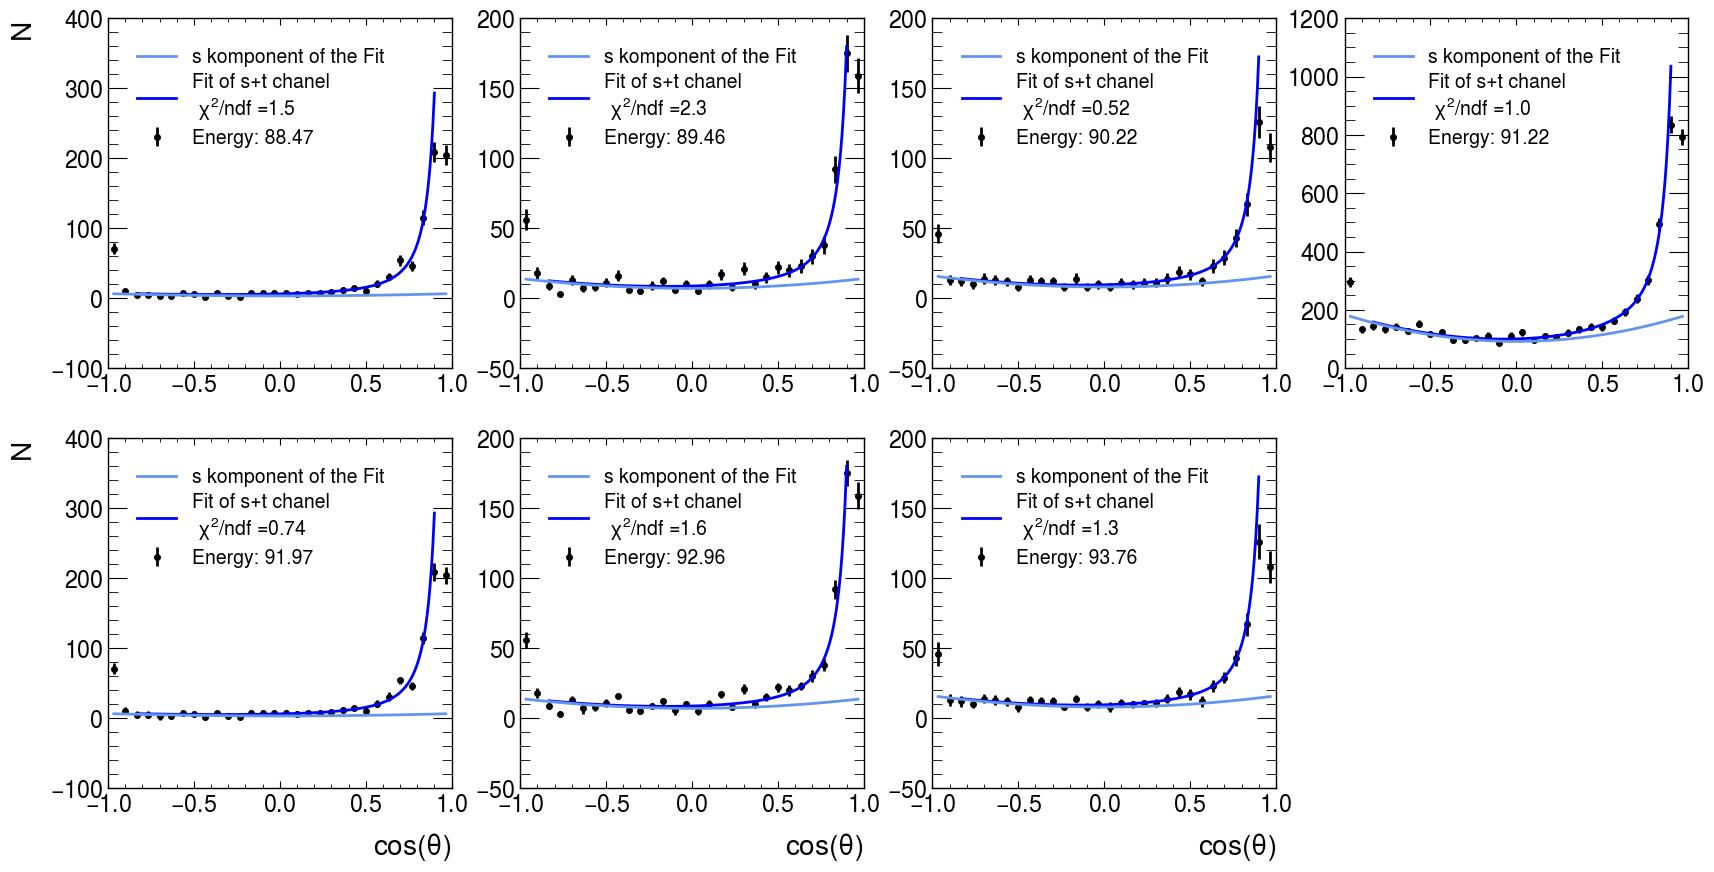

ratio s opal [0.07538809400863983, 0.17972032383243833, 0.2619005384591686, 0.3653106746147455, 0.32274820942722554, 0.1344598157764532, 0.23429886293482288]
ratio s opal error: [0.01370607709787726, 0.013895819396161446, 0.011076845189084248, 0.005892149716459651, 0.011369381865167843, 0.010508646833433158, 0.013569620656293614]


In [31]:
# Fitting
# Subtracting t channel
bin_min_opal = int(2)
bin_max_opal = int(27)

x_min = mid[bin_min_opal]
x_max = mid[bin_max_opal]
print('Range for fitting: cos(theta)=', x_min,'to', x_max)
fit_s_chan = []
fit_ts_chan = []
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
ax[-1, -1].axis('off')

energy = xs_corrections['energy']
ratio_s_opal = []
ratio_s_opal_err = []
chi_ts = np.zeros(7)
for ii in range(7):
    error_sizes = np.sqrt(opal_e_cut_E[ii])
    
    coeff, var_matrix = curve_fit(dsigdtheta, opal_e_cut_mid[ii][bin_min_opal:bin_max_opal], opal_e_cut_E[ii][bin_min_opal:bin_max_opal])
    hist_fit = dsigdtheta(mid[bin_min_opal:bin_max_opal], *coeff)
    fit_s_chan.append( sdsig(mid, coeff[0]))
    x = np.linspace(mid[2],mid[28],200)
    fit_ts_chan.append( dsigdtheta(x,*coeff))
    jj = ii
    line = 0 #line number
    if ii>3: #go into the second line
        line = 1 #second line
        ii = ii-4 #column number
        
    chi_ts[jj] = chi2(opal_e_cut_E[jj][bin_min_opal:bin_max_opal],dsigdtheta(opal_e_cut_mid[jj][bin_min_opal:bin_max_opal],*coeff),error_sizes[bin_min_opal:bin_max_opal], len(error_sizes[bin_min_opal:bin_max_opal])-2)
    im = ax[line, ii].errorbar(opal_e_cut_mid[ii], opal_e_cut_E[ii], yerr=error_sizes, label = 'Energy: {}'.format(energy[jj]), fmt=".", color=colors['mix'], zorder=1)
    im = ax[line, ii].plot(opal_e_cut_mid[ii],fit_s_chan[ii], zorder=3, label='s komponent of the Fit', color=colors['es'])
    im = ax[line, ii].plot(x,fit_ts_chan[ii], zorder=2, label=
                           'Fit of s+t chanel \n $ \chi ^2 / ndf $ ={:1.2}'.format(chi_ts[jj]), color=colors['e'])
    im = ax[line, ii].legend()
    
    ratio_s_opal.append(coeff[0] * (8 / 3) * len(fit_s_chan[ii]) / (sum(opalEcuts[ii])*2) )
    ratio_s_opal_err.append(np.sqrt(((8 / 3) * (len(fit_s_chan[ii]) / (sum(opalEcuts[ii])*2))**2) * var_matrix[0][0] + (coeff[0] * (8 / 3) * len(fit_s_chan[ii]) / (sum(opalEcuts[ii])*2)**2 )**2 * opalB_err[ii][0]**2))


ax[1,0].set_xlabel(r'$cos(\theta)$')
ax[1,1].set_xlabel(r'$cos(\theta)$')
ax[1,2].set_xlabel(r'$cos(\theta)$')
ax[0,0].set_ylabel('N')
ax[1,0].set_ylabel('N')

plt.show()
    
print('ratio s opal',ratio_s_opal)
print('ratio s opal error:', ratio_s_opal_err)

In [32]:
# apply s channel correction
opalB_corr = np.zeros((7,4))
ratio_s_opal[5] = ratio_s_opal[6] #s channel seperation does not work for data point 6, apply ratio of 7.
opalB_corr[:,1:] = np.array(opalB)[:,1:]

for ii in range(7):
    opalB_corr[ii][0] = opalB[ii][0] * ratio_s_opal[ii] #Multiply with the fraction of s channels
    opalB_err[ii][0] = np.sqrt(ratio_s_opal[ii]**2 * opalB_err[ii][0]**2 + opalB[ii][0]**2 * ratio_s_opal_err[ii]**2) #Error propagation

# Calculate cross section

In [33]:
# Optaining the cross sections using the Luminosities 
Sigma = [0] * 7
Sigma_err = [0] * 7

i = 0
while i < 7:
    # limi[i] is time integrated Luminosity
    Sigma[i] = opalB_corr[i] / lumi[i]
    Sigma_err[i] = [0] * 4
    
    # loop because opalB_err is list of arreys
    k = 0
    while k < 4:
        # Gaussian error propagation
        Sigma_err[i][k] = np.sqrt((1 / lumi[i])**2 * opalB_err[i][k]**2 + (opalB_corr[i][k] / lumi[i]**2)**2 * err_all_lumi[i]**2)
        k += 1
    Sigma_err[i] = np.array(Sigma_err[i])
    i += 1

# Printing all rescaled event counts
tpye = ['ee', 'mm', 'tt', 'qq']
for ii in range(4):
    print('\nSigma for {} events:'.format(tpye[ii]))
    for jj in range(7):
        print('Energy of LEP {} and Sigma = {:6.3f} +- {:4.3f}'.format(energy[jj], Sigma[jj][ii], Sigma_err[jj][ii]))


Sigma for ee events:
Energy of LEP 88.47 and Sigma =  0.241 +- 0.044
Energy of LEP 89.46 and Sigma =  0.636 +- 0.052
Energy of LEP 90.22 and Sigma =  0.935 +- 0.049
Energy of LEP 91.22 and Sigma =  1.439 +- 0.029
Energy of LEP 91.97 and Sigma =  1.038 +- 0.045
Energy of LEP 92.96 and Sigma =  0.600 +- 0.033
Energy of LEP 93.76 and Sigma =  0.577 +- 0.037

Sigma for mm events:
Energy of LEP 88.47 and Sigma =  0.225 +- 0.020
Energy of LEP 89.46 and Sigma =  0.507 +- 0.034
Energy of LEP 90.22 and Sigma =  0.932 +- 0.052
Energy of LEP 91.22 and Sigma =  1.446 +- 0.026
Energy of LEP 91.97 and Sigma =  1.250 +- 0.050
Energy of LEP 92.96 and Sigma =  0.645 +- 0.041
Energy of LEP 93.76 and Sigma =  0.499 +- 0.028

Sigma for tt events:
Energy of LEP 88.47 and Sigma =  0.319 +- 0.028
Energy of LEP 89.46 and Sigma =  0.512 +- 0.040
Energy of LEP 90.22 and Sigma =  0.796 +- 0.058
Energy of LEP 91.22 and Sigma =  1.522 +- 0.030
Energy of LEP 91.97 and Sigma =  1.245 +- 0.058
Energy of LEP 92.96 an

In [34]:
# apply ratiation correction
Sigma_corr = np.zeros((4,7))
Sigma_corr_err = np.zeros((4,7))
for ii in range(7):
    Sigma_corr[0,ii] = Sigma[ii][0] + xs_corrections['leptonic'][ii] #Add radiation correction
    Sigma_corr[1,ii] = Sigma[ii][1] + xs_corrections['leptonic'][ii]
    Sigma_corr[2,ii] = Sigma[ii][2] + xs_corrections['leptonic'][ii]
    Sigma_corr[3,ii] = Sigma[ii][3] + xs_corrections['hadronic'][ii]
    Sigma_corr_err[0,ii] = Sigma_err[ii][0]
    Sigma_corr_err[1,ii] = Sigma_err[ii][1]
    Sigma_corr_err[2,ii] = Sigma_err[ii][2]
    Sigma_corr_err[3,ii] = Sigma_err[ii][3]

# Plot and fit of cross sections

In [35]:
def relativistic_breit_wigner_normalized(x, resonance_mass, width, A):
    '''Relativistic Breit-Wigner normalized to an amplitude of one
    
    The Relativistic Breit-Wigner function was modiefied to
    scale the amplitude to one and use a parameter A, which describes
    the Amplitude (i.e. the cross section at the rsonance energy).
    
    Args:
        x (float): variable for the centre point energy
        resonance_mass (float): parameter descibing the position
        width (float): parameter descibing the width
        A (float): parameter descibing the amplitude
    '''
    gamma = np.sqrt(resonance_mass**2 * (resonance_mass ** 2 + width ** 2))
    k = 2.0 * np.sqrt(2) * resonance_mass * width * gamma / (np.pi * np.sqrt(resonance_mass ** 2 + gamma))
    return A * (resonance_mass**2 * width**2/k) *k / ((x ** 2 - resonance_mass ** 2) ** 2 + resonance_mass ** 2 * width ** 2)

In [36]:
# Fitting with the breit wegner function for electrons, muons, tauons and hadrons
listE = np.linspace(energy[0],energy[-1],1000) #Energy axis for the plot
bounds = [[90.0,0,1],[91.5,4,70]] #bounds for the fit
p0 = [91.2,1,2] # start parameters
coeff = np.zeros((4,3)) #dummy matrix for the coefficients

#Apply curve fit
coeff[0,:], var_matrix_e  = curve_fit(relativistic_breit_wigner_normalized, energy, Sigma_corr[0], sigma=Sigma_corr_err[0], absolute_sigma=True, p0 = p0, bounds = bounds)
coeff[1,:], var_matrix_m  = curve_fit(relativistic_breit_wigner_normalized, energy, Sigma_corr[1], sigma=Sigma_corr_err[1], absolute_sigma=True, p0 = p0, bounds = bounds)
coeff[2,:], var_matrix_t  = curve_fit(relativistic_breit_wigner_normalized, energy, Sigma_corr[2], sigma=Sigma_corr_err[2], absolute_sigma=True, p0 = p0, bounds = bounds)
coeff[3,:], var_matrix_h  = curve_fit(relativistic_breit_wigner_normalized, energy, Sigma_corr[3], sigma=Sigma_corr_err[3], absolute_sigma=True, p0 = p0, bounds = bounds)

fit_sigma = np.zeros((4,len(listE))) #Fitted sigmas for the plot
chi = np.zeros(4) #Chis square
for i in range(4):
    fit_sigma[i,:] = relativistic_breit_wigner_normalized(listE, *coeff[i,:])
    chi[i] = chi2(Sigma_corr[i],relativistic_breit_wigner_normalized(np.array(energy),*coeff[i,:]),Sigma_corr_err[i],ndf = 4)
print('Coefficients: Position [GeV], Width [GeV], Amplitude [nb] \n',coeff)
print('Chisquare vaalues for electrons, muons tauons, hadrons:', chi)

Coefficients: Position [GeV], Width [GeV], Amplitude [nb] 
 [[91.08695896  2.56525394  1.96084595]
 [91.20989985  2.52738824  1.9748408 ]
 [91.24138608  2.58951718  2.02451721]
 [91.19836619  2.53648241 41.0871358 ]]
Chisquare vaalues for electrons, muons tauons, hadrons: [5.66518424 2.1565817  1.68302839 4.63653228]


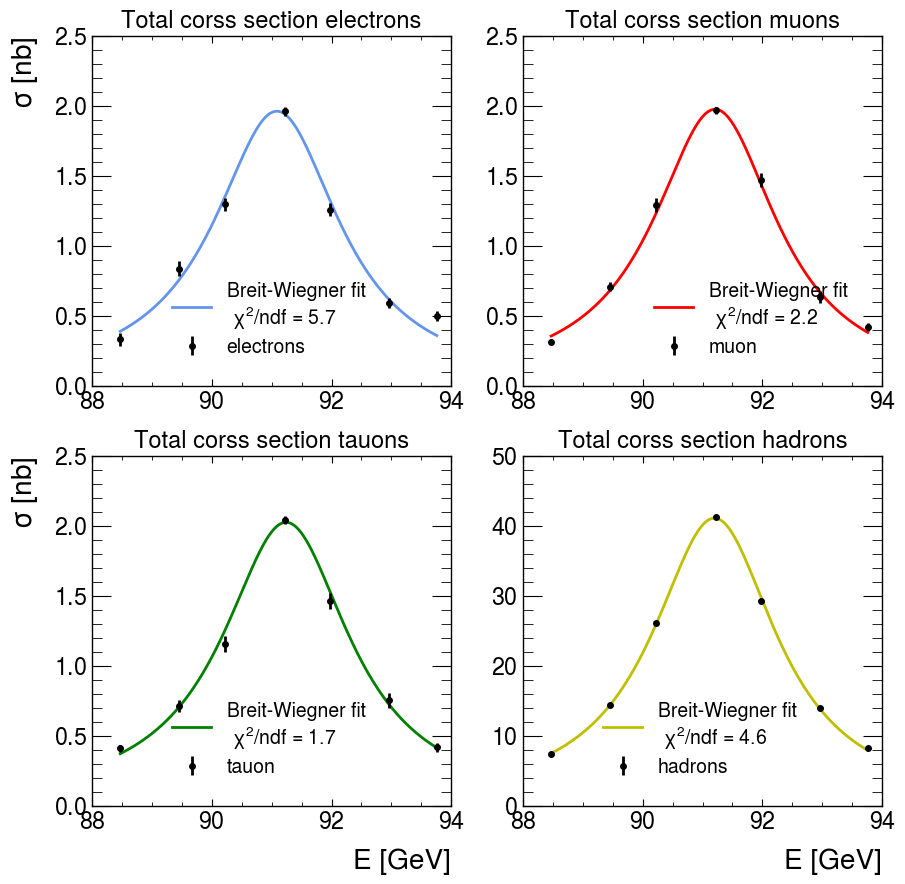

In [37]:
# Plotting the cross sections with the coresponding Breit-Wigner Fits

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

#fig.suptitle('Total crossection')
ax[0,0].errorbar(energy, Sigma_corr[0], yerr=Sigma_corr_err[0], label = 'electrons', fmt='.', color='black', zorder=2)
ax[0,1].errorbar(energy, Sigma_corr[1], yerr=Sigma_corr_err[1], label = 'muon', fmt='.', color='black', zorder=2)
ax[1,0].errorbar(energy, Sigma_corr[2], yerr=Sigma_corr_err[2], label = 'tauon', fmt='.', color='black', zorder=2)
ax[1,1].errorbar(energy, Sigma_corr[3], yerr=Sigma_corr_err[3], label = 'hadrons', fmt='.', color='black', zorder=2)

ax[0,0].plot(listE,fit_sigma[0,:], color=colors['es'], zorder=1, label = 'Breit-Wiegner fit \n $ \chi ^2 / ndf $ = {:1.2}'.format(chi[0]) )
ax[0,1].plot(listE,fit_sigma[1,:], color=colors['m'], zorder=1,label = 'Breit-Wiegner fit \n $ \chi ^2 / ndf $ = {:1.2}'.format(chi[1]) )
ax[1,0].plot(listE,fit_sigma[2,:], color=colors['t'], zorder=1, label = 'Breit-Wiegner fit \n $ \chi ^2 / ndf $ = {:1.2}'.format(chi[2]) )
ax[1,1].plot(listE,fit_sigma[3,:], color=colors['q'], zorder=1, label = 'Breit-Wiegner fit \n $ \chi ^2 / ndf $ = {:1.2}'.format(chi[3]) )

ax[0,0].set_ylim(0,2.5)
ax[0,0].title.set_text('Total corss section electrons')
ax[0,0].title.set_size('17')

ax[0,1].title.set_text('Total corss section muons')
ax[0,1].title.set_size('17')
ax[1,0].title.set_text('Total corss section tauons')
ax[1,0].title.set_size('17')
ax[1,1].title.set_text('Total corss section hadrons')
ax[1,1].title.set_size('17')
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

ax[1,1].set_xlabel('E [GeV]')
ax[1,0].set_xlabel('E [GeV]')
ax[0,0].set_ylabel(r'$\sigma$ [nb]')
ax[1,0].set_ylabel(r'$\sigma$ [nb]')
plt.show()

# Theoretical crossection

In [38]:
# Converting the ampltudes in nb into natural units (here MeV)
sig_e_conv = coeff[0,2] * 0.00257 * 1e-9
sig_m_conv = coeff[1,2] * 0.00257 * 1e-9
sig_t_conv = coeff[2,2] * 0.00257 * 1e-9
sig_h_conv = coeff[3,2] * 0.00257 * 1e-9

# Calculating the partial width of the e events
Gamma_e = np.sqrt(1/(12*np.pi) * sig_e_conv) * coeff[0,0]*1000 * coeff[0,1]*1000

# Using the partial width of the e events to calculate the other partial widths
Gamma_m = 1/(12*np.pi) * sig_m_conv * (coeff[1,0]*1000 * coeff[1,1]*1000)**2 / Gamma_e
Gamma_t = 1/(12*np.pi) * sig_t_conv * (coeff[2,0]*1000 * coeff[2,1]*1000)**2 / Gamma_e
Gamma_h = 1/(12*np.pi) * sig_h_conv * (coeff[3,0]*1000 * coeff[3,1]*1000)**2 / Gamma_e

print('Partial width\nGamma_e = {:3.2f}\nGamma_m = {:3.2f}\nGamma_t = {:3.2f}\nGamma_q = {:3.2f}'.format(Gamma_e, Gamma_m, Gamma_t, Gamma_h))

Partial width
Gamma_e = 85.43
Gamma_m = 83.74
Gamma_t = 90.19
Gamma_q = 1754.43


In [39]:
# Calculating the error on the partial widths
# Covariance termes are taken in to account because of the corelations between the parameters of the fits.
Gamma_e_err = np.sqrt((Gamma_e/coeff[0,0])**2 * var_matrix_e[0][0] + (Gamma_e/coeff[0,1])**2 * var_matrix_e[1][1] + (Gamma_e/coeff[0,2]/2)**2 * var_matrix_e[2][2] + 2*(Gamma_e/coeff[0,0])*(Gamma_e/coeff[0,1]) * var_matrix_e[1][0] + 2*(Gamma_e/coeff[0,0])*(Gamma_e/coeff[0,2]/2) * var_matrix_e[0][2] + 2*(Gamma_e/coeff[0,0])*(Gamma_e/coeff[0,0]) * var_matrix_e[1][0])

Gamma_m_err = np.sqrt((2*Gamma_m/coeff[1,0])**2 * var_matrix_m[0][0] + (2*Gamma_m/coeff[1,1])**2 * var_matrix_m[1][1] + (Gamma_m/coeff[1,2])**2 * var_matrix_m[2][2] + 2*(2*Gamma_m/coeff[1,0])*(2*Gamma_m/coeff[1,1]) * var_matrix_m[1][0] + 2*(2*Gamma_m/coeff[1,0])*(Gamma_m/coeff[1,2]) * var_matrix_m[0][2] + 2*(2*Gamma_m/coeff[1,1])*(Gamma_m/coeff[1,2]) * var_matrix_m[1][2] + (Gamma_m/Gamma_e)**2 * Gamma_e_err**2)

Gamma_t_err = np.sqrt((2*Gamma_t/coeff[2,0])**2 * var_matrix_t[0][0] + (2*Gamma_t/coeff[2,1])**2 * var_matrix_t[1][1] + (Gamma_t/coeff[2,2])**2 * var_matrix_t[2][2] + 2*(2*Gamma_t/coeff[2,0])*(2*Gamma_t/coeff[2,1]) * var_matrix_t[1][0] + 2*(2*Gamma_t/coeff[2,0])*(Gamma_t/coeff[2,2]) * var_matrix_t[2][0] + 2*(2*Gamma_t/coeff[2,1])*(Gamma_t/coeff[2,2]) * var_matrix_t[1][2] + (Gamma_t/Gamma_e)**2 * Gamma_e_err**2)

Gamma_h_err = np.sqrt((2*Gamma_h/coeff[3,0])**2 * var_matrix_h[0][0] + (2*Gamma_h/coeff[3,1])**2 * var_matrix_h[1][1] + (Gamma_h/coeff[3,2])**2 * var_matrix_h[2][2] + 2*(2*Gamma_h/coeff[3,0])*(2*Gamma_h/coeff[3,1]) * var_matrix_h[1][0] + 2*(2*Gamma_h/coeff[3,0])*(Gamma_h/coeff[3,2]) * var_matrix_h[2][0] + 2*(2*Gamma_h/coeff[3,1])*(Gamma_h/coeff[3,2]) * var_matrix_h[1][2] + (Gamma_h/Gamma_e)**2 * Gamma_e_err**2)


print('{:2.2f} {:2.2f} {:2.2f} {:2.2f}'.format(Gamma_e_err, Gamma_m_err, Gamma_t_err, Gamma_h_err))

2.38 3.92 4.76 51.78


In [40]:
# Apply a weighted mean to get the width of Z^0
Gamma_z_z = (coeff[0,1]/var_matrix_e[1][1]) + (coeff[1,1]/var_matrix_m[1][1]) + (coeff[2,1]/var_matrix_t[1][1]) + (coeff[3,1]/var_matrix_h[1][1])
Gamma_z_n = (1/var_matrix_e[1][1]) + (1/var_matrix_m[1][1]) + (1/var_matrix_t[1][1]) + (1/var_matrix_h[1][1])

Gamma_z = Gamma_z_z / Gamma_z_n * 1e3
Gamma_z_err = 1/np.sqrt(Gamma_z_n) * 1e3


print('Gamma_Z = ({:4.0f} +- {:2.0f}) MeV'.format(Gamma_z, Gamma_z_err))

Gamma_Z = (2540 +- 15) MeV


In [41]:
# Literature cross section
Gamma_l_lit = 83.8
Gamma_lit = 2.4952e3
Gamma_h_lit = 1744
Gamma_v_lit = 499
Mz_lit = 91.1876e3
Gamma_ve_lit = 167.6

sigma_lit = 12*np.pi/Mz_lit**2*Gamma_l_lit*Gamma_l_lit/Gamma_lit**2/0.00257*1e9
print(sigma_lit)

1.9897739378945132


In [42]:
# Neutrino Number

# Subtracting the  partial widths measured from the optained total width and deviding by the width of a neutrion
# The neutrino width is from literature (PDG)
N_neutrino = (Gamma_z - Gamma_e - Gamma_m - Gamma_t - Gamma_h ) / Gamma_ve_lit
Gamma_z_err = np.sqrt(var_matrix_e[1][1] + var_matrix_m[1][1] + var_matrix_t[1][1] + var_matrix_h[1][1])/4
N_n_err = np.sqrt(Gamma_z_err**2+Gamma_e_err**2+Gamma_m_err**2+Gamma_t_err**2+Gamma_h_err**2)/Gamma_ve_lit

print('Number of Neutrinos', N_neutrino, 'error:' ,N_n_err)

Number of Neutrinos 3.138699106168863 error: 0.3114707762890581


# Exercise 3: Forward-backward asymmetry and $\sin^2(\theta_\text{W})$ in muon final states

* Using the **muon channel only**, measure the forward-backward asymmetry $\mathcal{A}_\text{FB}$ using OPAL data and muon Monte Carlo events. Take into account the radiation corrections given below. 

| $\sqrt{s}$   \[GeV\]| Radiation correction [-]|  
| --- | --- | 
| 88.47 | 0.021512  | 
| 89.46 | 0.019262  | 
| 90.22 | 0.016713  | 
| 91.22 | 0.018293  | 
| 91.97 | 0.030286  | 
| 92.96 | 0.062196  | 
| 93.76 | 0.093850  | 

Feel free to use the dictionary 'radiation_corrections' given below.

* Measure the **Weinberg angle** as $\sin^2(\theta_\text{W})$. Compare the measurement with the literature.

In [43]:
radiation_corrections = { 'energy' : [ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76] ,
                          'correction' : [0.021512, 0.019262, 0.016713, 0.018293, 0.030286, 0.062196, 0.093850]}

In [44]:
# Calculating the Forward-Backward Asymmetry for muon data from OPAL
opalMcutsUP = [0] * 7
opalMcutsDOWN = [0] * 7
AFB = [0] * 7
AFB_err = [0] * 7

i = 0
while i < 7:
    UP0 = branchesopal['cos_thet'] >= 0
    UP1 = branchesopal['cos_thet'] <= .95
    DOWN0 = branchesopal['cos_thet'] < 0
    DOWN1 = branchesopal['cos_thet'] >= -.95
    opalMcutsUP[i] = opalMcuts[i] & UP0 & UP1# Mask with all muon data with positiv cos_thet
    opalMcutsDOWN[i] = opalMcuts[i] & DOWN0 & DOWN1# Mask with all muon data with negativ cos_thet
    
    # Sum over all positive (in cos_thet) data ponits
    Np = np.sum(opalMcutsUP[i])
    Np_err = np.sqrt(Np)
    # Sum over all negativ (in cos_thet) data ponits
    Nm = np.sum(opalMcutsDOWN[i])
    Nm_err = np.sqrt(Nm)
    
    # Calculating the Asymmetry
    AFB[i] = ((Np - Nm) / (Np + Nm)) + radiation_corrections['correction'][i]
    
    # Derivations of the Asymmetry for the Forward and Backward Numbers
    dNp = (2*Nm / (Np + Nm)**2)
    dNm = (2*Np / (Np + Nm)**2)
    
    # Gaussian Error probagation
    AFB_err[i] = np.sqrt(Np_err**2 * dNp**2 + Nm_err**2 * dNm**2)
    i += 1
print(AFB)
print(AFB_err)

[-0.14384233070866143, 0.02827100900900901, -0.12435283072100312, 0.005391545155091958, 0.022558024729520867, 0.262196, 0.1948271986970684]
[0.08751413588024098, 0.06711288183958318, 0.05542937078358304, 0.016566633621962503, 0.03931288273179025, 0.06259686371487612, 0.0567812995476232]


In [45]:
def Lin(x,a,b):
    '''Linear Function
    
    Linear function used to Fit the Forward-Backward Asymmetry.
    
    Args:
        x (float): variable for the centre point energy
        a (float): parameter describing the slope
        b (float): parameter describing the axes intersection
    '''
    return ((a*x) + b)

In [46]:
# Do a linear fit through the Forward-Backward Asymmetry at diffent energies in order to detirmain the Asymmetry at the resonance
LinParam, LinCovar = curve_fit(Lin, energy, AFB, sigma=AFB_err, absolute_sigma=True)


AFB_resonance = Lin(coeff[1,0], *LinParam)# reading the linear fit at the resonance
# Calculating the derivations of the Fit function for the parameters and the resonance energy
chi_AFB = chi2(AFB, Lin(np.array(energy),*LinParam),np.array(AFB_err), 7-2)

dE = LinParam[0]
da = coeff[1,0]
db = 1
# Using the derivations to calculate the error of the Asymmetry at resonance.
# The parameters of the fit are corelated, therefor the covariance between them is takn in to acount.
AFB_resonance_err = np.sqrt(dE**2 * var_matrix_m[0][0] + da**2 * LinCovar[0][0] + db**2 * LinCovar[1][1] + 2 * da * db * LinCovar[0][1])

print(r'A_FB = ',' ({:4.3f} +- {:4.3f})'.format(AFB_resonance, AFB_resonance_err))
print('Fit chi^2/ndf', chi_AFB)

A_FB =   (0.011 +- 0.014)
Fit chi^2/ndf 2.2866116262961276


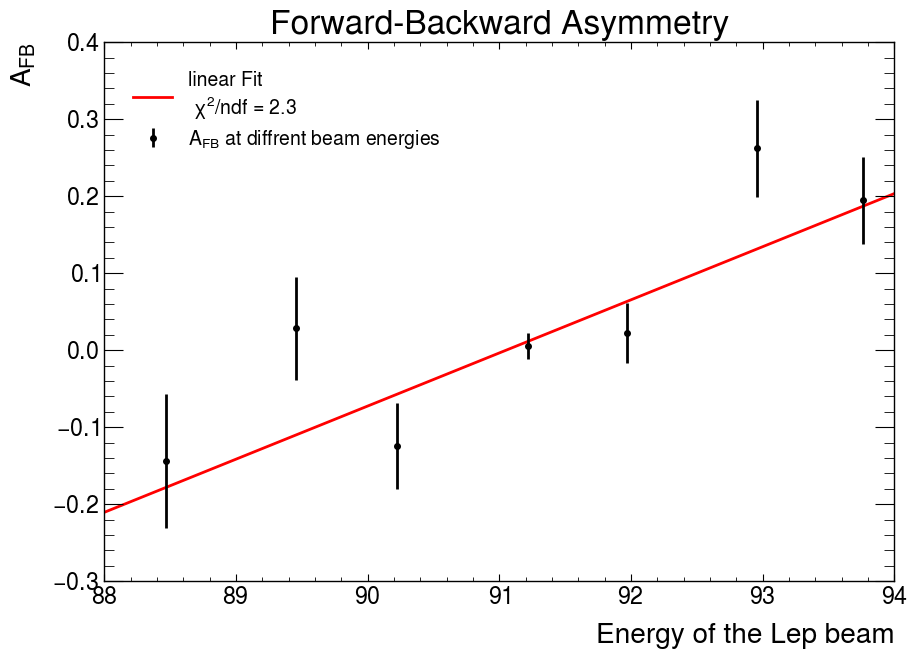

In [47]:
# Ploting the Asymmetry at diffent energies with the linear Fit
plt.style.use(mplhep.style.ATLAS)
plt.figure(figsize=figsize)

plt.errorbar(energy, AFB, yerr=AFB_err, zorder=2, label = r'$A_{FB}$ at diffrent beam energies', color='black', fmt=".")# r'$A_{FB}$ at diffrent beam energies'
x = np.linspace(88, 94, 2)
plt.plot(x, Lin(x, *LinParam), zorder=1, label='linear Fit \n $ \chi^2/ndf$ = {:1.2}'.format(chi_AFB), color=colors['m'])

plt.legend()
plt.title('Forward-Backward Asymmetry')
plt.xlabel('Energy of the Lep beam')
plt.ylabel(r'$A_{FB}$')
plt.show()

In [48]:
# Using the Asymmetry at the resonance to calculate the Weinberg angle
Weinberg = 1/4 * (1-np.sqrt(abs(AFB_resonance)/3))
Weinberg_err = np.sqrt((-np.sqrt(1/3) / (8 * np.sqrt(abs(AFB_resonance))))**2 * (AFB_resonance_err)**2)

print('({:4.4f} +- {:4.4f})'.format(Weinberg, Weinberg_err))

(0.2349 +- 0.0095)


In [49]:
# Calculating the Forward-Backward Asymmetry for muon MC data
UP0 = brancheses[1]['cos_thet'] >=0
UP1 = brancheses[1]['cos_thet'] <= .95#1
DOWN0 = brancheses[1]['cos_thet'] < 0
DOWN1 = brancheses[1]['cos_thet'] >= -.95#-1
MC_McutsUP = UP0 & UP1
MC_McutsDOWN = DOWN0 & DOWN1

Np = np.sum(MC_McutsUP)
Np_err = np.sqrt(Np)
Nm = np.sum(MC_McutsDOWN)
Nm_err = np.sqrt(Nm)

MC_AFB = ((Np - Nm) / (Np + Nm)) + radiation_corrections['correction'][3]

dNp = (2*Nm / (Np + Nm)**2)
dNm = (2*Np / (Np + Nm)**2)

MC_AFB_err = np.sqrt(Np_err**2 * dNp**2 + Nm_err**2 * dNm**2)

print(MC_AFB)
print(MC_AFB_err)

0.02357019457527095
0.0033687519184111892


In [50]:
# Calculating the Weinberg angle for MC data
MC_Weinberg = 1/4 * (1-np.sqrt(MC_AFB/3))
MC_Weinberg_err = np.sqrt((-np.sqrt(1/3)/(8 * np.sqrt(MC_AFB)))**2 * (MC_AFB_err)**2)
print(MC_Weinberg, MC_Weinberg_err)

0.22784044855331803 0.0015835684174932859


# Exercise 4: Tests on lepton universality¶

* Test the lepton universality from the total cross sectinos on the peak for $Z\to e^+ e^-$, $Z\to \mu^+ \mu^-$ and $Z\to \tau^+ \tau^-$ events. What is the ratio of the total cross section of the hadronic channel to the leptonic channels on the peak? Compare with the ratios obtained from the branching rations and discuss possible differences.

In [51]:
# Comparing the cross sections for the leptons
print('Sigma')
print('{:4.3f} +- {:4.3f}'.format(coeff[0,2], np.sqrt(var_matrix_e[2,2])))
print('{:4.3f} +- {:4.3f}'.format(coeff[1,2], np.sqrt(var_matrix_m[2,2])))
print('{:4.3f} +- {:4.3f}\n'.format(coeff[2,2], np.sqrt(var_matrix_t[2,2])))


# Comparing the ratios of the cross sections for the leptons to the cross section of the hadrons
E_ratio = coeff[0,2] / coeff[3,2]
M_ratio = coeff[1,2] / coeff[3,2]
T_ratio = coeff[2,2] / coeff[3,2]

E_ratio_err = np.sqrt((1/coeff[3,2])**2 * (var_matrix_e[2,2])**2 + (-coeff[0,2]/coeff[3,2]**2)**2 * (var_matrix_h[2,2])**2)
M_ratio_err = np.sqrt((1/coeff[3,2])**2 * (var_matrix_m[2,2])**2 + (-coeff[1,2]/coeff[3,2]**2)**2 * (var_matrix_h[2,2])**2)
T_ratio_err = np.sqrt((1/coeff[3,2])**2 * (var_matrix_h[2,2])**2 + (-coeff[2,2]/coeff[3,2]**2)**2 * (var_matrix_h[2,2])**2)

print('Sigma ratio')
print('{:5.5f} +- {:5.5f}'.format(E_ratio, E_ratio_err))
print('{:5.5f} +- {:5.5f}'.format(M_ratio, M_ratio_err))
print('{:5.5f} +- {:5.5f}\n'.format(T_ratio, T_ratio_err))

# Comparing the ratios of the partial widths of the leptons to the width of the hadrons
E_ratio_branch = Gamma_e / Gamma_h
M_ratio_branch = Gamma_m / Gamma_h
T_ratio_branch = Gamma_t / Gamma_h

E_ratio_branch_err = np.sqrt((1/Gamma_h)**2 * Gamma_e_err**2 + (Gamma_e/Gamma_h**2)**2 * Gamma_h_err**2)
M_ratio_branch_err = np.sqrt((1/Gamma_h)**2 * Gamma_m_err**2 + (Gamma_m/Gamma_h**2)**2 * Gamma_h_err**2)
T_ratio_branch_err = np.sqrt((1/Gamma_h)**2 * Gamma_t_err**2 + (Gamma_t/Gamma_h**2)**2 * Gamma_h_err**2)

print('Branching')
print('{:4.4f} +- {:4.4f}'.format(E_ratio_branch, E_ratio_branch_err))
print('{:4.4f} +- {:4.4f}'.format(M_ratio_branch, M_ratio_branch_err))
print('{:4.4f} +- {:4.4f}'.format(T_ratio_branch, T_ratio_branch_err))

Sigma
1.961 +- 0.030
1.975 +- 0.025
2.025 +- 0.029

Sigma ratio
0.04772 +- 0.00006
0.04806 +- 0.00006
0.04927 +- 0.00119

Branching
0.0487 +- 0.0020
0.0477 +- 0.0026
0.0514 +- 0.0031


# Grope Data
The data sown below was obtained from the Grope data set and was used for a initial depiction of the different variables resulting from different types of fermions.

In [52]:
G_runs = [0] * 5
G_events = [0] * 5
G_eleps = [0] * 5
G_nchares = [0] * 5
G_pchares = [0] * 5
G_eecals = [0] * 5
G_ehcals = [0] * 5

fs = ['ee', 'mm', 'tt', 'qq']

j = 0
while j < 4:
    eefile = open('opal_data/grope/'+fs[j]+'_ex.txt').read()
    eefile = eefile.split('\n')

    N = len(eefile) - 1

    e_run = [0] * N
    e_event = [0] * N
    e_elep = [0] * N
    e_nchare = [0] * N
    e_pchare = [0] * N
    e_eecal = [0] * N
    e_ehcal = [0] * N

    for i in range(1,N):
        if j == 0:
            line = eefile[i].split('\t')
            e_run[i] = float(line[0])
            e_event[i] = float(line[1])
            e_elep[i] = float(line[2])
            e_nchare[i] = float(line[3])
            e_pchare[i] = float(line[4])
            e_eecal[i] = float(line[6])
            e_ehcal[i] = float(line[8])
        else:
            line = eefile[i].split('\t')
            e_run[i] = float(line[0])
            e_event[i] =float(line[1])
            e_elep[i] = float(line[2])
            e_nchare[i] = float(line[3])
            
            try:
                e_pchare[i] = float(line[4])
            except:
                e_pchare[i] = 0
            try:
                e_eecal[i] = float(line[5])
            except:
                e_eecal[i] = 0
            e_ehcal[i] = float(line[6])
    
    G_runs[j] = e_run
    G_events[j] = e_event
    G_eleps[j] = e_elep
    G_nchares[j] = e_nchare
    G_pchares[j] = e_pchare
    G_eecals[j] = e_eecal
    G_ehcals[j] = e_ehcal
    
    j += 1

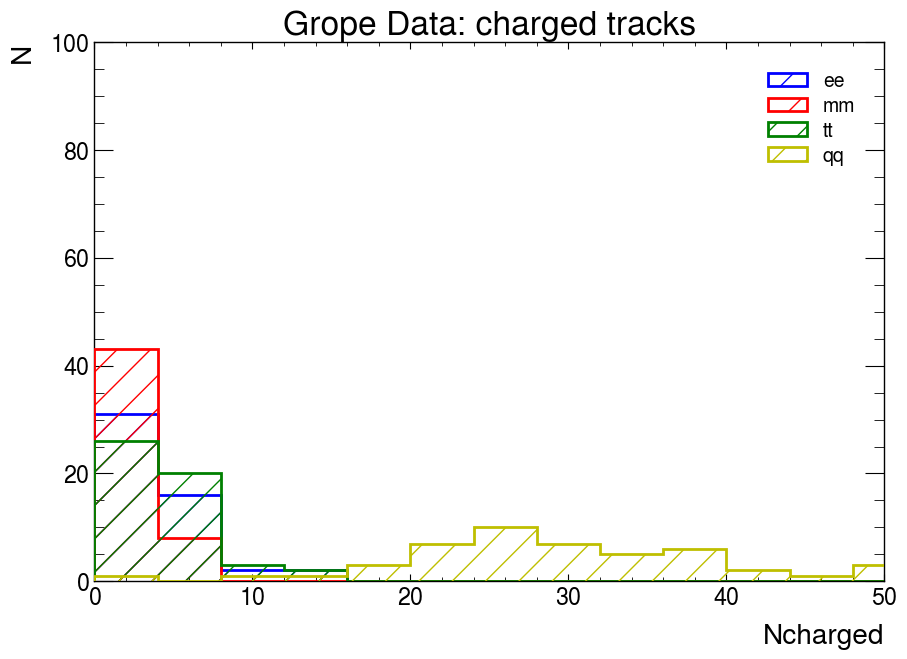

In [53]:
plt.style.use(mplhep.style.ATLAS)
plt.figure(figsize=figsize)

bin_content, bin_edges, _ = plt.hist(G_nchares[0], bins=25, range=(0.,100.), histtype='step',  linewidth=2, edgecolor=colors['e'], hatch='', label='ee', zorder=2)
bin_content, bin_edges, _ = plt.hist(G_nchares[1], bins=25, range=(0.,100.), histtype='step',  linewidth=2, edgecolor=colors['m'], hatch='', label='mm', zorder=3)
bin_content, bin_edges, _ = plt.hist(G_nchares[2], bins=25, range=(0.,100.), histtype='step',  linewidth=2, edgecolor=colors['t'], hatch='', label='tt', zorder=4)
bin_content, bin_edges, _ = plt.hist(G_nchares[3], bins=25, range=(0.,100.), histtype='step',  linewidth=2, edgecolor=colors['q'], hatch='', label='qq', zorder=5)

plt.legend()
plt.title('Grope Data: charged tracks')
plt.xlim(0.,50)
plt.ylim(0,6e1)
plt.xlabel('Ncharged')
plt.ylabel('N')
plt.savefig('Plots/G_N_charged.svg', bbox_inches='tight')
plt.show()

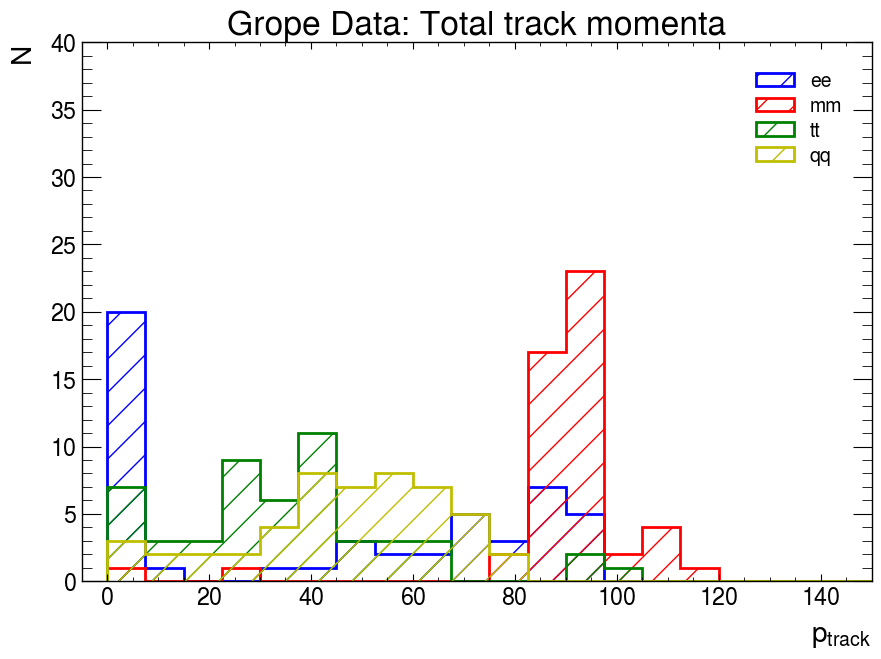

In [54]:
plt.style.use(mplhep.style.ATLAS)
plt.figure(figsize=figsize)

bin_content, bin_edges, _ = plt.hist(G_pchares[0], bins=20, range=(0.,150.), histtype='step',  linewidth=2, edgecolor=colors['e'], hatch='', label='ee')
bin_content, bin_edges, _ = plt.hist(G_pchares[1], bins=20, range=(0.,150.), histtype='step',  linewidth=2, edgecolor=colors['m'], hatch='', label='mm')
bin_content, bin_edges, _ = plt.hist(G_pchares[2], bins=20, range=(0.,150.), histtype='step',  linewidth=2, edgecolor=colors['t'], hatch='', label='tt')
bin_content, bin_edges, _ = plt.hist(G_pchares[3], bins=20, range=(0.,150.), histtype='step',  linewidth=2, edgecolor=colors['q'], hatch='', label='qq')

plt.legend()
plt.title('Grope Data: Total track momenta')
plt.xlim(-5,150.)
plt.ylim(0,4e1)
plt.xlabel('$p_{track}$')
plt.ylabel('N')
plt.savefig('Plots/G_P_charged.svg', bbox_inches='tight')
plt.show()

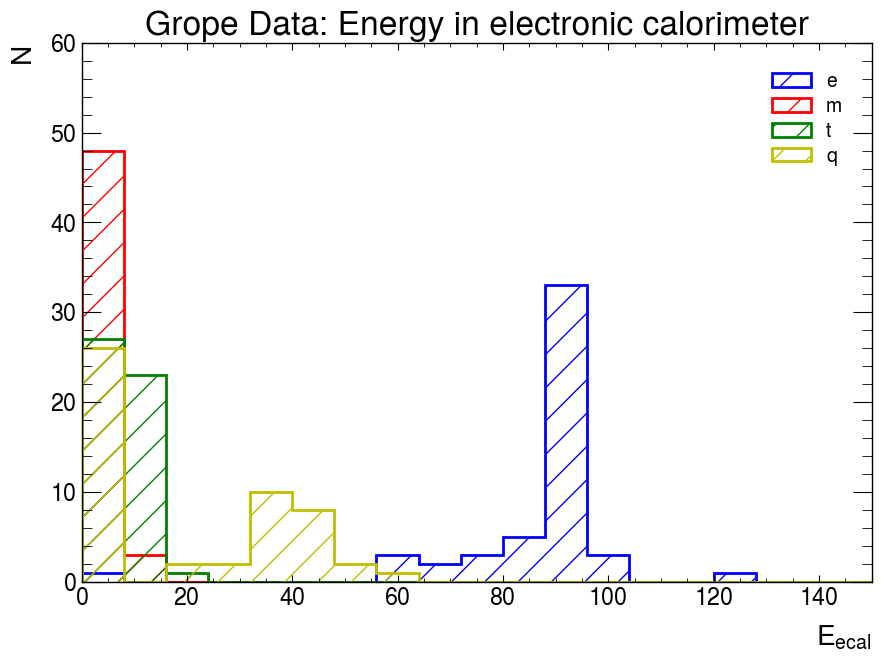

In [55]:
plt.style.use(mplhep.style.ATLAS)
plt.figure(figsize=figsize)

bin_content, bin_edges, _ = plt.hist(G_eecals[0], bins=25, range=(0.,200.), histtype='step',  linewidth=2, edgecolor=colors['e'], hatch='', label='e')
bin_content, bin_edges, _ = plt.hist(G_eecals[1], bins=25, range=(0.,200.), histtype='step',  linewidth=2, edgecolor=colors['m'], hatch='', label='m')
bin_content, bin_edges, _ = plt.hist(G_eecals[2], bins=25, range=(0.,200.), histtype='step',  linewidth=2, edgecolor=colors['t'], hatch='', label='t')
bin_content, bin_edges, _ = plt.hist(G_eecals[3], bins=25, range=(0.,200.), histtype='step',  linewidth=2, edgecolor=colors['q'], hatch='', label='q')

plt.legend()
plt.title('Grope Data: Energy in electronic calorimeter')
plt.xlim(0.,150.)
plt.ylim(0,.6e2)
plt.xlabel('$E_{ecal}$')
plt.ylabel('N')
plt.savefig('Plots/G_E_ecal.svg', bbox_inches='tight')
plt.show()

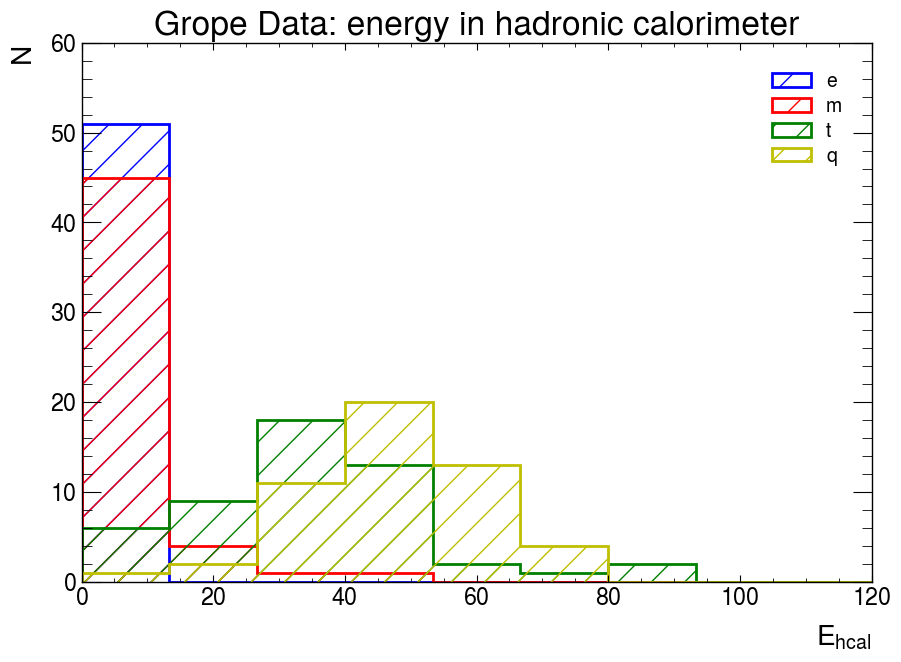

In [56]:
plt.style.use(mplhep.style.ATLAS)
plt.figure(figsize=figsize)

bin_content, bin_edges, _ = plt.hist(G_ehcals[0], bins=15, range=(0.,200.), histtype='step',  linewidth=2, edgecolor=colors['e'], hatch='', label='e')
bin_content, bin_edges, _ = plt.hist(G_ehcals[1], bins=15, range=(0.,200.), histtype='step',  linewidth=2, edgecolor=colors['m'], hatch='', label='m')
bin_content, bin_edges, _ = plt.hist(G_ehcals[2], bins=15, range=(0.,200.), histtype='step',  linewidth=2, edgecolor=colors['t'], hatch='', label='t')
bin_content, bin_edges, _ = plt.hist(G_ehcals[3], bins=15, range=(0.,200.), histtype='step',  linewidth=2, edgecolor=colors['q'], hatch='', label='q')

plt.legend()
plt.title('Grope Data: energy in hadronic calorimeter')
plt.xlim(0.,120)
plt.ylim(0,.6e2)
plt.xlabel('$E_{hcal}$')
plt.ylabel('N')
plt.savefig('Plots/G_E_hcal.svg', bbox_inches='tight')
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'sight'

<Figure size 1000x700 with 0 Axes>

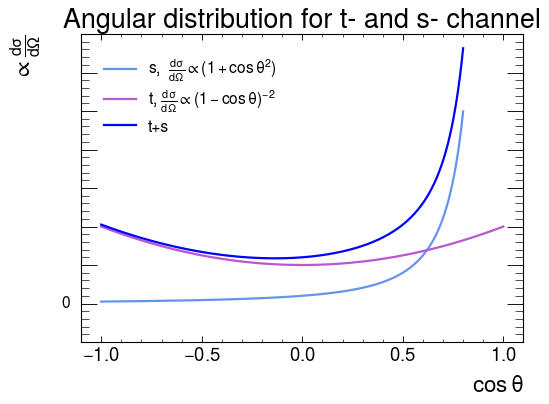

In [57]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=figsize)

x = np.linspace(-1,1,1000)
y1 = 5*(1+x**2)
y2 = (1-x[:900])**(-2)
y3 = y1[:900]+y2


fig = plt.figure(figsize = (7, 5), dpi = 80)
plt.plot(x[:900],y2, color = colors['es'], label = r's,  $ \frac{d\sigma}{d\Omega} \propto (1+\cos{\theta}^2)$' )
plt.plot(x,y1, color = colors['et'], label = r't, $ \frac{d\sigma}{d\Omega} \propto (1-\cos{\theta})^{-2} $' )
plt.plot(x[:900],y3,color = colors['e'], label = 't+s')

plt.xlim(-1.1,1.1)
plt.text(-1.2,-0.5, '0')
#plt.yticks([0], color ='k')
plt.yticks(color='w')
plt.legend()
plt.ylabel(r' $\propto \frac{d \sigma}{d  \Omega}$')
plt.xlabel(r' $\cos{\theta}$')
plt.title('Angular distribution for t- and s- channel')
#plt.show()
#plt.sight
plt.savefig('Plots/angular_distribution.svg')